# **气象预测大作业**

# 一、项目概述

### 项目概述

本项目的核心目标是优化天气预测模型，使用深度学习方法进行时序预测，尤其专注于不同模型在捕捉天气数据时序特征和周期性规律的表现。为了实现这一目标，我们使用了多种深度学习架构，如LSTM、ResNet和Transformer，并针对时序数据的预测任务进行了创新性优化，尤其是动态模型选择和模型融合策略。

### 关键改进和亮点：

1. **时序数据预测**：
    在项目初期，我们学习了Img2Img和Seq2Img的模型结构，但随着对气象预测需求的深入分析，时序预测成为了项目的核心部分。我们采用了深度学习模型来捕捉天气数据的时序依赖关系，并使用带有自注意力机制的Transformer模型，重点关注如何利用时间和周期性特征（如小时和月份的周期性）来提高预测的准确性。
2. **动态模型选择**：
    针对不同天气状态（如稳定、趋势、拐点），我们引入了动态模型选择机制。当温度变化较小时，我们使用Transformer模型进行预测；当温度发生较大波动时，我们切换到ResNet模型进行更精确的建模；而LSTM模型则在温度变化平稳时发挥其优势。通过这种动态选择，我们能够根据实时的天气数据调整模型，提高预测性能。
3. **模型融合（Meta-Learner）**：
    为了进一步提升预测准确性，我们采用了Meta-Learner模型融合策略。通过将Transformer、LSTM和ResNet模型的预测结果作为输入，利用XGBoost进行学习和优化，最终得到了一个强大的Meta-Learner模型。该模型综合了多个基础模型的优点，并有效地提升了整体预测精度。

### 项目重点：

- **数据准备**：从北京气候数据中提取温度、风速、湿度等特征，并进行了标准化处理和周期性特征的引入（如小时和月份的正弦余弦编码）。
- **深度学习模型**：
  - **LSTM**：处理时间序列数据的经典模型，能够捕捉长期依赖关系。
  - **ResNet**：用于捕捉局部时序变化和复杂的气象特征，特别是在短期内有大波动的情况下表现优秀。
  - **Transformer**：借助自注意力机制，可以捕捉长期和短期的时间依赖，尤其适合处理较长时间跨度的数据。
- **动态模型推理**：基于温度变化的趋势判断（如稳定、趋势、拐点），动态选择最合适的模型进行推理，并使用最新的模型状态进行预测。
- **Meta-Learner**：将多个模型的输出结果作为特征，利用XGBoost训练一个强大的模型进行最终预测，从而提升整体预测性能。

# 二、前置工作

In [ ]:
# 安装 ClimateLearn 库
!pip install climate-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 

In [2]:
# Google Drive，用来存储数据和模型结果
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [ ]:
# 导入所需的库
import climate_learn as cl
from climate_learn.data.processing.nc2npz import convert_nc2npz
from IPython.display import HTML
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary,
    RichProgressBar
)
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
import torch

# 三、数据获取

本项目所使用的数据来源于 欧洲中期天气预报中心（ECMWF）发布的 ERA5 再分析数据集，该数据集为全球气象研究与建模提供了高质量、时空分辨率高、变量丰富的大气变量信息。为便于深度学习模型的快速加载和处理，本项目使用经过 WeatherBench 项目标准化格式的 ERA5 数据，并通过开源工具库 ClimateLearn 进行下载和预处理。

ERA5 数据覆盖全球范围，具有每小时至每日的时间分辨率和多种气象要素变量。其在气象建模中广泛应用，尤其适用于构建数据驱动的天气预测模型。



## 3.1 数据来源
本项目采用 ClimateLearn 提供的 download_weatherbench() 接口直接从 WeatherBench 官方服务器获取标准 ERA5 子集数据。下载完成后，通过 convert_nc2npz() 函数将 .nc 文件转换为 .npz 格式，并划分为训练集、验证集与测试集，供神经网络模型调用。



## 3.2 数据集配置

数据源：ERA5（ECMWF 再分析数据）

获取方式：ClimateLearn 工具库 + WeatherBench 数据结构

空间分辨率：1.40625° × 1.40625°（全球网格数据）

时间分辨率：6 小时 / 每帧（Subsample=6）

时间范围：

训练集：1979 - 2014

验证集：2015 - 2016

测试集：2017 - 2018



## 3.3 选取的气象变量
项目初期阶段（模型结构学习阶段），遵循教学内容，我们选用了以下 6 个与人体体感密切相关的气象变量，以便于模型的基本训练与可视化分析：

| 变量名称   | ERA5 变量名                       | 单位   | 说明                      |
| ------ | ------------------------------ | ---- | ----------------------- |
| 2米气温   | `2m_temperature`               | K    | 表示地面附近空气温度，直接影响人体感知     |
| 相对湿度   | `relative_humidity`            | %    | 描述空气湿度状况，影响闷热、舒适度       |
| 总降水量   | `total_precipitation`          | m    | 表示一定时间内的地表降水总量          |
| 总云量    | `total_cloud_cover`            | 0–1  | 表示天空被云层覆盖的比例            |
| 顶层太阳辐射 | `toa_incident_solar_radiation` | W/m² | 表示从太阳入射到大气顶端的能量密度       |
| 涡度     | `vorticity`                    | 1/s  | 表征大气流体的旋转强度，利于识别涡旋等天气系统 |


在掌握基本流程后，我进一步构建并训练了自己的深度学习模型。在此阶段，我自定义选取了 ERA5 数据中的以下 8 个变量，以增强模型对风场、水汽、温度场结构的刻画能力：



```

var_map = {
    'u10': '10m_u_component_of_wind',
    'v10': '10m_v_component_of_wind',
    't2m': '2m_temperature',
    'z': 'geopotential',
    'q': 'specific_humidity',
    't': 'temperature',
    'u': 'u_component_of_wind',
    'v': 'v_component_of_wind'
}
```


此外，我选取北京区域（纬度 39.9°，经度 116.4°）作为目标站点区域，对相应变量进行局地提取与建模实验，并将每个变量分别保存以便模型调用与分析，此阶段的变量选择更侧重于对大气动力、水汽输送与温度结构的综合建模，体现了我在项目中对数据理解和特征选择的进一步深化。



## 3.4 具体下载流程

In [ ]:
# 下载2米温度（2m_temperature）
cl.data.download_weatherbench(
    dst="/content/drive/MyDrive/ClimateLearn/2m_temperature",
    dataset="era5",
    variable="2m_temperature"
)

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dataserv.ub.tum.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
# 下载相对湿度（relative_humidity）
cl.data.download_weatherbench(
    dst="/content/drive/MyDrive/ClimateLearn/relative_humidity",
    dataset="era5",
    variable="relative_humidity"
)

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dataserv.ub.tum.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
# 下载总降水量（total_precipitation）
cl.data.download_weatherbench(
    dst="/content/drive/MyDrive/ClimateLearn/total_precipitation",
    dataset="era5",
    variable="total_precipitation"
)


In [ ]:
# 下载总云量（total_cloud_cover）
cl.data.download_weatherbench(
    dst="/content/drive/MyDrive/ClimateLearn/total_cloud_cover",
    dataset="era5",
    variable="total_cloud_cover"
)

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dataserv.ub.tum.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
# 下载顶层太阳辐射（toa_incident_solar_radiation）
cl.data.download_weatherbench(
    dst="/content/drive/MyDrive/ClimateLearn/toa_incident_solar_radiation",
    dataset="era5",
    variable="toa_incident_solar_radiation"
)


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dataserv.ub.tum.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
# 下载涡度（vorticity）
cl.data.download_weatherbench(
    dst="/content/drive/MyDrive/ClimateLearn/vorticity",
    dataset="era5",
    variable="vorticity"
)

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dataserv.ub.tum.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
# 下载10m 东向和北向风速
variables = [
    "10m_u_component_of_wind",
    "10m_v_component_of_wind"
]

for var in variables:
    try:
        cl.data.download_weatherbench(
            dst=f"/content/drive/MyDrive/ClimateLearn/{var}",
            dataset="era5",
            variable=var
        )
        print(f"成功下载：{var}")
    except Exception as e:
        print(f"下载失败：{var}")
        print("错误信息：", e)

In [ ]:
# 下载气温
cl.data.download_weatherbench(
    dst="/content/drive/MyDrive/ClimateLearn/temperature",
    dataset="era5",
    variable="temperature"
)

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dataserv.ub.tum.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
# 配置下载的路径和变量
base_path = '/content/drive/MyDrive/ClimateLearn'

# 下载的变量列表
variables = [
     ("geopotential", "高空气数据 - 位势高度"),
     ("specific_humidity", "高空气数据 - 比湿度"),
    ("v_component_of_wind", "高空气数据 - v 分量风速"),
    ("u_component_of_wind", "高空气数据 - u 分量风速")

]

# 循环下载每个变量
for var, description in variables:
    try:
        print(f"开始下载 {description} ...")
        cl.data.download_weatherbench(
            dst=f"{base_path}/{var}",  # 数据存储的路径
            dataset="era5",
            variable=var,
        )
        print(f"{description} 下载完成！")
    except Exception as e:
        # 错误处理，打印错误信息
        print(f"下载失败：{description}")
        print("错误信息：", e)
        continue  # 如果发生错误，继续下载下一个变量


开始下载 高空气数据 - v 分量风速 ...


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dataserv.ub.tum.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


高空气数据 - v 分量风速 下载完成！


# 四、数据预处理

## 4.1 检查 .nc 文件是否齐全

Google Drive /ClimateLearn/ ，已经有这些子文件夹，每个里面包含 1979–2018 的 .nc 文件：

```
/ClimateLearn/
├── 2m_temperature/
├── relative_humidity/
├── total_precipitation/
├── total_cloud_cover/
├── toa_incident_solar_radiation/
├── vorticity/
├── 10m_u_component_of_wind/
├── 10m_v_component_of_wind/
├── temperature/


```






## 4.2 执行预处理（.nc → .npz）

In [ ]:
from climate_learn.data.processing.nc2npz import convert_nc2npz

convert_nc2npz(
    root_dir="/content/drive/MyDrive/ClimateLearn",  # 原始.nc文件路径
    save_dir="/content/drive/MyDrive/ClimateLearn/processed",  # 转换后保存位置
    variables=[
        "2m_temperature",
        "relative_humidity",
        "total_precipitation",
        "total_cloud_cover",
        "toa_incident_solar_radiation",
        "vorticity"
    ],
    start_train_year=1979,
    start_val_year=2015,
    start_test_year=2017,
    end_year=2018,
    num_shards=16  # 默认分片
)

100%|██████████| 1/1 [01:24<00:00, 84.19s/it]



## 4.3 处理结果
```
/ClimateLearn/processed/
├── train/
├── val/
├── test/
```
这些 .npz 文件将作为模型的输入。

# 五、基线模型评估

由于 ERA5 数据天然区分为不同的气压层（pressure levels）与地表层（surface level），我们在本项目中聚焦于与人类体感密切相关的层级变量，进行建模与预测。


我们选用如下变量与层级进行建模：

| 类型 | 变量名（in\_vars / out\_vars）      | 层级      | 选择理由                          |
| -- | ------------------------------ | ------- | ----------------------------- |
| 温度 | `2m_temperature`               | 地表      | 直接决定体感温度                      |
| 湿度 | `relative_humidity_850`        | 850 hPa | 接近人体活动高度，反映闷热程度与舒适度           |
| 云量 | `total_cloud_cover`            | 地表      | 影响光照强度、可见度与体感舒适性              |
| 辐射 | `toa_incident_solar_radiation` | 地表/顶层   | 决定热感与紫外线暴露水平，影响灼热感            |
| 涡度 | `vorticity_850`                | 850 hPa | 靠近地面系统扰动层，能揭示中低层涡旋与局地强对流等天气特征 |
| 降水 | `total_precipitation`          | 地表      | 直接反映降水事件，影响出行、穿衣与体感湿冷程度       |





为探索不同时间建模策略对气象预测效果的影响，我们在实验中分别采用了两种典型的预测结构：

| 预测形式        | 含义      | 输入              | 输出           | 应用示例                                 |
| ----------- | ------- | --------------- | ------------ | ------------------------------------ |
| **Img2Img** | 图像 → 图像 | 某一时刻的空间图（如温度）   | 未来某一时刻的空间图   | 当前时刻温度图 → 预测未来 6 小时的温度图              |
| **Seq2Img** | 序列 → 图像 | 多个时刻的图像序列（时间窗口） | 某一未来时刻的空间图   | 输入过去 24 小时的温度序列 → 预测未来第 24 小时的温度分布   |




## 5.1 Seq2Img：用过去 3 个时间点（即过去 18 小时），预测未来 24 小时后的一帧图像

### 5.1.1 数据模块定义

In [ ]:
# 运行基线部分
dm_seq2img = cl.data.IterDataModule(
    # Seq2Img
    task="direct-forecasting",
    inp_root_dir="/content/drive/MyDrive/ClimateLearn/processed",
    out_root_dir="/content/drive/MyDrive/ClimateLearn/processed",
    in_vars=[
        "2m_temperature",
        "relative_humidity_850",
        "total_precipitation",
        "total_cloud_cover",
        "toa_incident_solar_radiation",
        "vorticity_850"
    ],
    # 预测的目标变量
    out_vars=[
        "2m_temperature",
        "total_precipitation"
    ],
    src="era5",
    subsample=6, # 每6小时一次
    pred_range=24, # 预测24小时后
    history=3,
    batch_size=32
)
dm_seq2img.setup()


### 5.1.2 加载基线模型 & 测试性能

In [ ]:
climatology = cl.load_forecasting_module(
    data_module=dm_seq2img,
    architecture="climatology"
)

persistence = cl.load_forecasting_module(
    data_module=dm_seq2img,
    architecture="persistence"
)

trainer = pl.Trainer()
trainer.test(climatology, dm_seq2img)
trainer.test(persistence, dm_seq2img)


### 5.1.3 可视化单张预测（对比预测 vs 真实）

0it [00:00, ?it/s]
<ipython-input-14-6337898a5e59>:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  denorm_temp = lambda x: x * std + mean


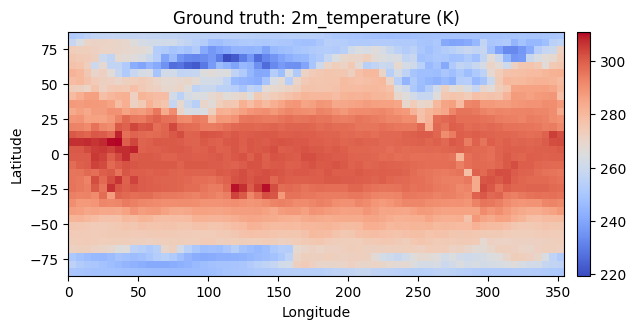

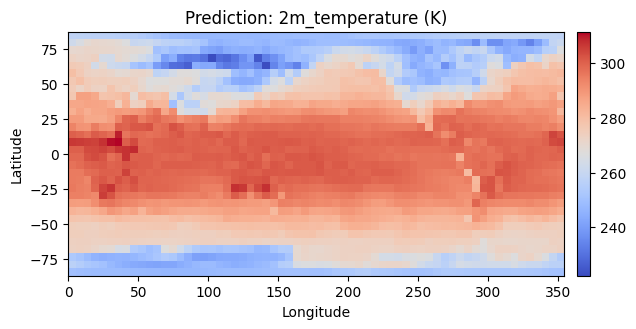

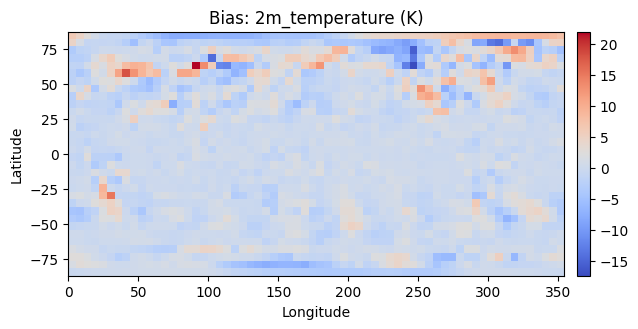

In [ ]:
import numpy as np
from IPython.display import HTML

# 读取标准化参数，只针对单个变量
mean = np.load("/content/drive/MyDrive/ClimateLearn/processed/normalize_mean.npz")["2m_temperature"]
std = np.load("/content/drive/MyDrive/ClimateLearn/processed/normalize_std.npz")["2m_temperature"]

# 构造反归一化函数
denorm_temp = lambda x: x * std + mean

# 可视化函数
graphic = cl.utils.visualize_at_index(
    persistence,
    dm_seq2img,
    in_transform=denorm_temp,
    out_transform=denorm_temp,
    variable="2m_temperature",
    src="era5",
    index=0
)

HTML(graphic.to_jshtml())


### 5.1.4 可视化预测误差空间偏差图（Bias Map）



0it [00:00, ?it/s]<ipython-input-14-6337898a5e59>:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  denorm_temp = lambda x: x * std + mean
43it [00:06,  6.35it/s]


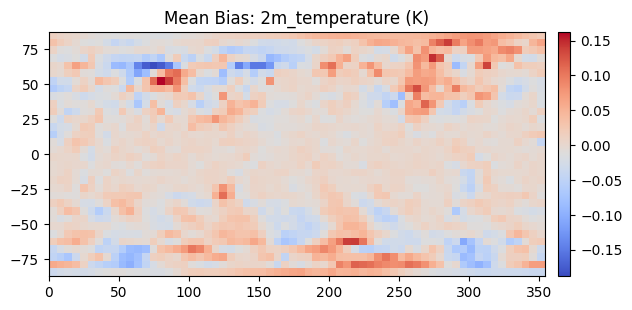

In [ ]:
# 画出温度预测的平均偏差分布
cl.utils.visualize_mean_bias(
    dm_seq2img,
    persistence,
    out_transform=denorm_temp,
    variable="2m_temperature", # 可改为total_precipitation
    src="era5"
)


## 5.2 Img2Img：用当前时间的图像，预测未来一帧

### 5.2.1 数据模块定义

In [ ]:
# 运行基线部分
dm_img2img = cl.data.IterDataModule(
    task="direct-forecasting",
    inp_root_dir="/content/drive/MyDrive/ClimateLearn/processed",
    out_root_dir="/content/drive/MyDrive/ClimateLearn/processed",
    in_vars=[
        "2m_temperature",
        "relative_humidity_850",
        "total_precipitation",
        "total_cloud_cover",
        "toa_incident_solar_radiation",
        "vorticity_850"
    ],
    out_vars=[
        "2m_temperature",
        "total_precipitation"
    ],
    src="era5",
    subsample=6,        # 每 6 小时一帧
    pred_range=6,       # 预测 6 小时后
    history=1,          # 只使用当前时间点
    batch_size=32
)
dm_img2img.setup()


### 5.2.2 加载基线模型 & 测试性能

In [ ]:
climatology = cl.load_forecasting_module(
    data_module=dm_img2img, architecture="climatology"
)
persistence = cl.load_forecasting_module(
    data_module=dm_img2img, architecture="persistence"
)

trainer = pl.Trainer()
trainer.test(climatology, dm_img2img)
trainer.test(persistence, dm_img2img)


Loading architecture: climatology
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform


INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: denormalize
Loading test transform: denormalize
Loading architecture: persistence
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: denormalize
Loading test transform: denormalize


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric            ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/lat_acc:2m_temperature    │       -0.005049085098044145       │
│      test/lat_acc:aggregate       │       -0.002310436626471666       │
│ test/lat_acc:total_precipitation  │       0.0004282118451007943       │
│   test/lat_rmse:2m_temperature    │         5.821098833521879         │
│      test/lat_rmse:aggregate      │        3.1610272250193936         │
│ test/lat_rmse:total_precipitation │        0.5009556165169068         │
└───────────────────────────────────┴───────────────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric            ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/lat_acc:2m_temperature    │        0.8483440499577695         │
│      test/lat_acc:aggregate       │        0.7216952277755359         │
│ test/lat_acc:total_precipitation  │        0.5950464055933021         │
│   test/lat_rmse:2m_temperature    │         2.783131996249394         │
│      test/lat_rmse:aggregate      │         1.616027115545128         │
│ test/lat_rmse:total_precipitation │        0.4489222348408625         │
└───────────────────────────────────┴───────────────────────────────────┘

[{'test/lat_rmse:2m_temperature': 2.783131996249394,
  'test/lat_rmse:total_precipitation': 0.4489222348408625,
  'test/lat_rmse:aggregate': 1.616027115545128,
  'test/lat_acc:2m_temperature': 0.8483440499577695,
  'test/lat_acc:total_precipitation': 0.5950464055933021,
  'test/lat_acc:aggregate': 0.7216952277755359}]

### 5.2.3 可视化单张预测（对比预测 vs 真实）


In [ ]:
import numpy as np
from IPython.display import HTML

# 读取标准化参数，只针对单个变量
mean = np.load("/content/drive/MyDrive/ClimateLearn/processed/normalize_mean.npz")["2m_temperature"]
std = np.load("/content/drive/MyDrive/ClimateLearn/processed/normalize_std.npz")["2m_temperature"]

# 构造反归一化函数
denorm_temp = lambda x: x * std + mean


# 可视化函数
graphic = cl.utils.visualize_at_index(
    persistence,
    dm_img2img,
    in_transform=denorm_temp,
    out_transform=denorm_temp,
    variable="2m_temperature",
    src="era5",
    index=0
)



### 5.2.4 可视化预测误差空间偏差图（Bias Map）

0it [00:00, ?it/s]<ipython-input-14-6337898a5e59>:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  denorm_temp = lambda x: x * std + mean
45it [00:04,  9.10it/s]


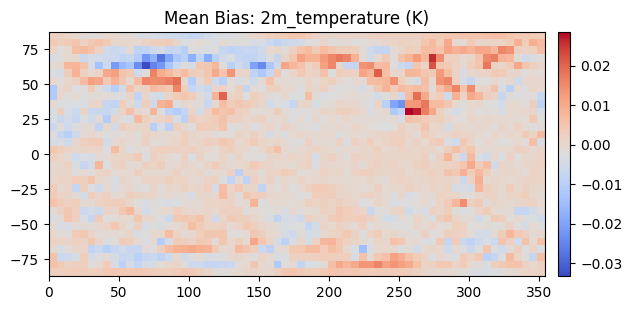

In [ ]:
# 画出温度预测的平均偏差分布
cl.utils.visualize_mean_bias(
    dm_img2img,
    persistence,
    out_transform=denorm_temp,
    variable="2m_temperature", # 可改为total_precipitation
    src="era5"
)


# 六、ResNet模型

## 6.1. Seq2Img

In [ ]:
# 加载 ResNet 模型
resnet_seq2img = cl.load_forecasting_module(
    data_module=dm_seq2img,
    architecture="rasp-theurey-2020"
)

Loading architecture: rasp-theurey-2020
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: denormalize
Loading test transform: denormalize


In [ ]:
#配置训练器，进行训练
pl.seed_everything(0)
default_root_dir = f"resnet_forecasting_24hrs"
logger = TensorBoardLogger(save_dir=f"{default_root_dir}/logs")
early_stopping = "val/lat_mse:aggregate"
callbacks = [
    RichProgressBar(),
    RichModelSummary(max_depth=1),
    EarlyStopping(
        monitor=early_stopping,
        patience=5
    ),
    ModelCheckpoint(
        dirpath=f"{default_root_dir}/checkpoints",
        monitor=early_stopping,
        filename="epoch_{epoch:03d}",
        auto_insert_metric_name=False,
    )
]
trainer = pl.Trainer(
    logger=logger,
    callbacks=callbacks,
    default_root_dir=default_root_dir,
    accelerator="cuda" if torch.cuda.is_available() else "cpu",
    devices=[0] if torch.cuda.is_available() else 1,
    max_epochs=1,
    precision="16"
)

INFO:lightning_fabric.utilities.seed:Seed set to 0
/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# ResNet 测试
trainer.fit(resnet_seq2img, datamodule=dm_seq2img)

trainer.test(resnet_seq2img, datamodule=dm_seq2img, ckpt_path="best")


0it [00:16, ?it/s]
<ipython-input-20-43e94983de65>:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  denorm_temp = lambda x: x * std + mean


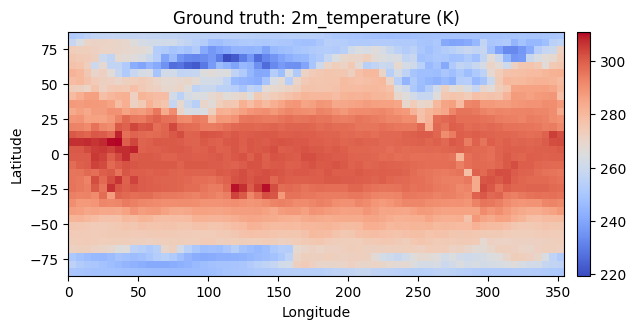

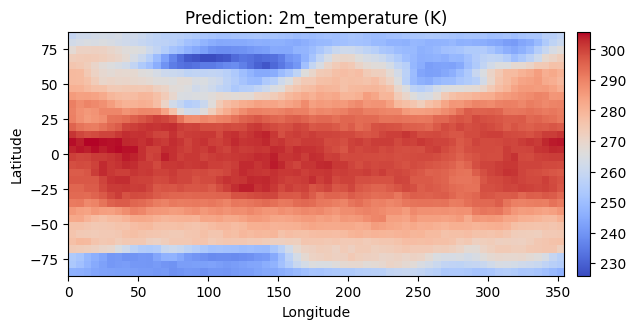

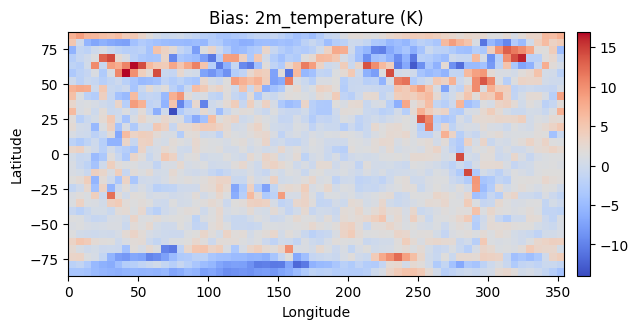

In [ ]:
# 可视化
# 为 2m_temperature 构造 denorm
mean = np.load("/content/drive/MyDrive/ClimateLearn/processed/normalize_mean.npz")["2m_temperature"]
std = np.load("/content/drive/MyDrive/ClimateLearn/processed/normalize_std.npz")["2m_temperature"]

denorm_temp = lambda x: x * std + mean

# 将模型转到 CPU 并设置为 eval 模式
resnet_cpu = resnet_seq2img.to("cpu").eval()

# 上下文中关闭梯度追踪
import torch
with torch.no_grad():
    in_graphic = cl.utils.visualize_at_index(
        resnet_cpu,
        dm_seq2img,
        in_transform=denorm_temp,
        out_transform=denorm_temp,
        variable="2m_temperature",
        src="era5",
        index=0
    )



## 6.2 Img2Img

In [ ]:
# 加载 ResNet 模型
resnet_img2img = cl.load_forecasting_module(
    data_module=dm_img2img,
    architecture="rasp-theurey-2020"
)

Loading architecture: rasp-theurey-2020
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: denormalize
Loading test transform: denormalize


In [ ]:
#配置训练器，进行训练
pl.seed_everything(0)
default_root_dir = f"resnet_forecasting_24hrs"
logger = TensorBoardLogger(save_dir=f"{default_root_dir}/logs")
early_stopping = "val/lat_mse:aggregate"
callbacks = [
    RichProgressBar(),
    RichModelSummary(max_depth=1),
    EarlyStopping(
        monitor=early_stopping,
        patience=5
    ),
    ModelCheckpoint(
        dirpath=f"{default_root_dir}/checkpoints",
        monitor=early_stopping,
        filename="epoch_{epoch:03d}",
        auto_insert_metric_name=False,
    )
]
trainer = pl.Trainer(
    logger=logger,
    callbacks=callbacks,
    default_root_dir=default_root_dir,
    accelerator="cuda" if torch.cuda.is_available() else "cpu",
    devices=[0] if torch.cuda.is_available() else 1,
    max_epochs=1,
    precision="16"
)

INFO:lightning_fabric.utilities.seed:Seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# ResNet 测试
trainer.fit(resnet_img2img, datamodule=dm_img2img)

trainer.test(resnet_img2img, datamodule=dm_img2img, ckpt_path="best")


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name ┃ Type   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ net  │ ResNet │  5.7 M │ train │
└───┴──────┴────────┴────────┴───────┘

Trainable params: 5.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.7 M                                                                                                
Total estimated model params size (MB): 22                                                                         
Modules in train mode: 238                                                                                         
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without 
rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g.
`anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/resnet_forecasting_24hrs/checkpoints/epoch_000-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/resnet_forecasting_24hrs/checkpoints/epoch_000-v1.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric            ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/lat_acc:2m_temperature    │        0.8557729782624557         │
│      test/lat_acc:aggregate       │        0.7730610059626344         │
│ test/lat_acc:total_precipitation  │        0.6903490336628125         │
│   test/lat_rmse:2m_temperature    │        2.7273668200781986         │
│      test/lat_rmse:aggregate      │         1.544172924442368         │
│ test/lat_rmse:total_precipitation │         0.36097902880654          │
└───────────────────────────────────┴───────────────────────────────────┘

[{'test/lat_rmse:2m_temperature': 2.7273668200781986,
  'test/lat_rmse:total_precipitation': 0.36097902880654,
  'test/lat_rmse:aggregate': 1.544172924442368,
  'test/lat_acc:2m_temperature': 0.8557729782624557,
  'test/lat_acc:total_precipitation': 0.6903490336628125,
  'test/lat_acc:aggregate': 0.7730610059626344}]

0it [00:12, ?it/s]
<ipython-input-30-8bb2890f2c2d>:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  denorm_temp = lambda x: x * std + mean


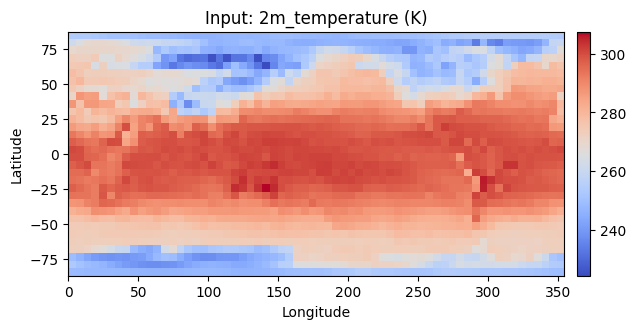

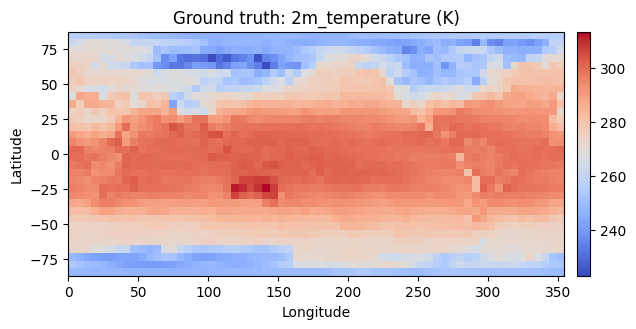

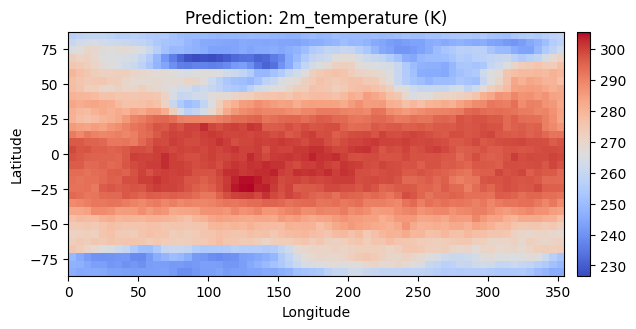

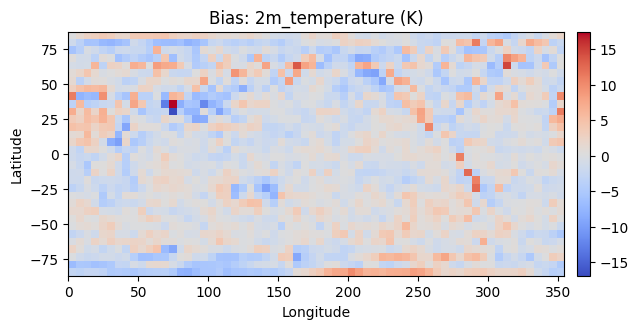

In [ ]:
# 可视化
# 为 2m_temperature 构造 denorm
mean = np.load("/content/drive/MyDrive/ClimateLearn/processed/normalize_mean.npz")["2m_temperature"]
std = np.load("/content/drive/MyDrive/ClimateLearn/processed/normalize_std.npz")["2m_temperature"]

denorm_temp = lambda x: x * std + mean

# 将模型转到 CPU 并设置为 eval 模式
resnet_cpu = resnet_img2img.to("cpu").eval()

# 上下文中关闭梯度追踪
import torch
with torch.no_grad():
    in_graphic = cl.utils.visualize_at_index(
        resnet_cpu,
        dm_img2img,
        in_transform=denorm_temp,
        out_transform=denorm_temp,
        variable="2m_temperature",
        src="era5",
        index=0
    )



# 七、模型训练数据准备


## 7.1 数据处理

In [ ]:
import xarray as xr
import pandas as pd
import os

# 设置根路径（你的数据文件目录）
base_path = '/content/drive/MyDrive/ClimateLearn'

# 要提取的变量和对应文件夹名（文件夹名称按你实际存放情况改）
var_map = {
    'u10': '10m_u_component_of_wind',
    'v10': '10m_v_component_of_wind',
    't2m': '2m_temperature',
    'z': 'geopotential',
    'q': 'specific_humidity',
    't': 'temperature',
    'u': 'u_component_of_wind',
    'v': 'v_component_of_wind'
}

# 北京经纬度
target_lat = 39.9
target_lon = 116.4

# 初始化总数据表
df_all = None

for var_name, folder in var_map.items():
    folder_path = os.path.join(base_path, folder)
    if not os.path.exists(folder_path):
        print(f"文件夹不存在：{folder_path}")
        continue

    files = sorted(os.listdir(folder_path))
    series_list = []

    for file in files:
        if not file.endswith('.nc'):
            continue

        file_path = os.path.join(folder_path, file)
        ds = xr.open_dataset(file_path)

        # 获取变量名
        var_data = ds[list(ds.data_vars)[0]].sel(lat=target_lat, lon=target_lon, method='nearest')

        # 转为 DataFrame
        df = var_data.to_dataframe().reset_index()[['time', var_data.name]]
        df = df.rename(columns={var_data.name: var_name})
        series_list.append(df)

    # 合并一个变量的所有时间
    if series_list:
        df_var = pd.concat(series_list)

        if df_all is None:
            df_all = df_var
        else:
            df_all = pd.merge(df_all, df_var, on='time', how='outer')

# 去重 + 排序
df_all = df_all.drop_duplicates(subset='time').sort_values('time')

# 保存为 CSV
output_path = '/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv'
df_all.to_csv(output_path, index=False)

print(f'提取完毕，保存为 {output_path}')
print(df_all.head())


### 准备变量映射 + 设置路径

In [ ]:
import os

# 设置根路径（你存放原始气候数据的目录）
base_path = '/content/drive/MyDrive/ClimateLearn'

# 要提取的变量和对应子文件夹名（按你实际命名来改）
var_map = {
    'u10': '10m_u_component_of_wind',
    'v10': '10m_v_component_of_wind',
    't2m': '2m_temperature',
    'z': 'geopotential',
    'q': 'specific_humidity',
    't': 'temperature',
    'u': 'u_component_of_wind',
    'v': 'v_component_of_wind'
}

# 设置目标经纬度（北京为例）
target_lat = 39.9
target_lon = 116.4

# 设置输出路径（每个变量单独保存）
output_dir = '/content/drive/MyDrive/Keras-LSTM'
os.makedirs(output_dir, exist_ok=True)


### 定义提取函数（每个变量单独运行，避免 RAM 爆炸）

In [ ]:
import xarray as xr
import pandas as pd
from tqdm import tqdm

def extract_single_variable(var_name, folder_name, output_csv):
    folder_path = os.path.join(base_path, folder_name)
    if not os.path.exists(folder_path):
        print(f"文件夹不存在：{folder_path}")
        return

    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.nc')])
    series_list = []

    print(f"正在提取变量 {var_name} ...")

    for file in tqdm(files):
        file_path = os.path.join(folder_path, file)
        try:
            ds = xr.open_dataset(file_path)
            var_data = ds[list(ds.data_vars)[0]].sel(lat=target_lat, lon=target_lon, method='nearest')
            df = var_data.to_dataframe().reset_index()[['time', var_data.name]]
            df = df.rename(columns={var_data.name: var_name})
            series_list.append(df)
            ds.close()
        except Exception as e:
            print(f"读取失败：{file_path}，原因：{e}")
            continue

    if series_list:
        df_var = pd.concat(series_list).drop_duplicates(subset='time').sort_values('time')
        df_var.to_csv(output_csv, index=False)
        print(f"{var_name} 保存完成：{output_csv}")
    else:
        print(f"{var_name} 没有成功提取任何数据。")


### 依次处理每个变量 + 最终合并

In [ ]:
# 第一步：提取每个变量并保存为单独 CSV 文件
for var, folder in var_map.items():
    output_csv = os.path.join(output_dir, f"series_{var}.csv")
    if not os.path.exists(output_csv):
        extract_single_variable(var, folder, output_csv)
    else:
        print(f"已存在，跳过：{output_csv}")

# 第二步：合并所有 CSV 到一个总表
import glob

csv_files = sorted(glob.glob(os.path.join(output_dir, "series_*.csv")))
df_all = None

print("开始合并各变量数据 ...")
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    if df_all is None:
        df_all = df
    else:
        df_all = pd.merge(df_all, df, on='time', how='outer')

df_all = df_all.drop_duplicates(subset='time').sort_values('time')
final_output = os.path.join(output_dir, "beijing_climate_series.csv")
df_all.to_csv(final_output, index=False)
print(f"最终合并完成，保存为：{final_output}")


正在提取变量 u10 ...


100%|██████████| 40/40 [02:32<00:00,  3.81s/it]


u10 保存完成：/content/drive/MyDrive/Keras-LSTM/series_u10.csv
正在提取变量 v10 ...


100%|██████████| 40/40 [02:12<00:00,  3.31s/it]


v10 保存完成：/content/drive/MyDrive/Keras-LSTM/series_v10.csv
正在提取变量 t2m ...


100%|██████████| 40/40 [02:24<00:00,  3.61s/it]


t2m 保存完成：/content/drive/MyDrive/Keras-LSTM/series_t2m.csv
正在提取变量 z ...


100%|██████████| 40/40 [09:34<00:00, 14.35s/it]


z 保存完成：/content/drive/MyDrive/Keras-LSTM/series_z.csv
正在提取变量 q ...


100%|██████████| 40/40 [08:43<00:00, 13.09s/it]


q 保存完成：/content/drive/MyDrive/Keras-LSTM/series_q.csv
正在提取变量 t ...


100%|██████████| 40/40 [07:49<00:00, 11.73s/it]


t 保存完成：/content/drive/MyDrive/Keras-LSTM/series_t.csv
正在提取变量 u ...


100%|██████████| 40/40 [09:13<00:00, 13.84s/it]


u 保存完成：/content/drive/MyDrive/Keras-LSTM/series_u.csv
正在提取变量 v ...


100%|██████████| 40/40 [14:08<00:00, 21.22s/it]


v 保存完成：/content/drive/MyDrive/Keras-LSTM/series_v.csv
🔗 开始合并各变量数据 ...
最终合并完成，保存为：/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv


In [ ]:
# 加载合并后的数据
merged_data = pd.read_csv('/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv')

# 查看前几行数据
print(merged_data.head())

# 如果需要查看详细的统计信息，可以使用 describe()
print(merged_data.describe())

                  time         q          t        t2m          u       u10  \
0  1979-01-01 00:00:00  0.000003  221.76671  254.36868  23.028270  2.655685   
1  1979-01-01 01:00:00  0.000003  221.95163  255.33621  23.099470  1.980127   
2  1979-01-01 02:00:00  0.000003  221.74385  258.74835  22.058636  2.266697   
3  1979-01-01 03:00:00  0.000003  221.43103  267.90903  20.716522  2.191001   
4  1979-01-01 04:00:00  0.000003  221.04973  268.87845  19.659279  2.189528   

          v       v10          z  
0  1.839203  0.194773  199116.50  
1  0.359176  0.298050  199322.94  
2 -0.336078  0.266928  199368.81  
3 -0.756803  0.370176  199365.53  
4 -0.553885  0.261989  199247.56  
                  q              t            t2m              u  \
count  3.506400e+05  350640.000000  350640.000000  350640.000000   
mean   2.769975e-06     216.446405     277.739081      10.804305   
std    1.905750e-07       3.061626      13.240933      12.165169   
min    2.242625e-06     199.043800     241.

## 7.2 标准化并转换成监督学习模式

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.model_selection import train_test_split

# 配置路径
input_path = '/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv'  # 路径应指向刚生成的合并数据
output_path = '/content/drive/MyDrive/Keras-LSTM/beijing_climate_scaled.csv'
scaler_path = '/content/drive/MyDrive/Keras-LSTM/scaler.save'
n_steps = 6
target_cols = ['t2m']  # 预测变量（可改）

# 1. 读取原始数据
df = pd.read_csv(input_path, parse_dates=['time'])  # 注意列名
df = df.sort_values('time')

# 2. 缺失值填充
if df.isnull().any().any():
    df = df.fillna(method='ffill')

# 3. 分离时间与数值列
time = df['time']
data = df.drop(columns=['time'])

# 4. 标准化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
scaled_df['time'] = time.values
scaled_df.to_csv(output_path, index=False)
joblib.dump(scaler, scaler_path)

print("标准化完成并保存！")

# 5. 构造 LSTM 输入数据
feature_cols = [col for col in scaled_df.columns if col != 'time']
target_indices = [feature_cols.index(col) for col in target_cols]
data_array = scaled_df[feature_cols].values

def create_lstm_dataset(data, target_indices, n_steps=6):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i, target_indices])
    return np.array(X), np.array(y)

X, y = create_lstm_dataset(data_array, target_indices, n_steps)
print(f"LSTM 数据形状：X.shape = {X.shape}, y.shape = {y.shape}")

# 6. 划分训练和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 7. 保存数据集
np.save('/content/drive/MyDrive/Keras-LSTM/X_train.npy', X_train)
np.save('/content/drive/MyDrive/Keras-LSTM/X_test.npy', X_test)
np.save('/content/drive/MyDrive/Keras-LSTM/y_train.npy', y_train)
np.save('/content/drive/MyDrive/Keras-LSTM/y_test.npy', y_test)

print("数据集构建完成并已保存！")


标准化完成并保存！
LSTM 数据形状：X.shape = (350634, 6, 8), y.shape = (350634, 1)
数据集构建完成并已保存！


# 八、Transformer训练


## 8.1 数据预处理与加载

In [ ]:
# 加载数据并查看基本信息
df = pd.read_csv(csv_path)
print("数据列名:")
print(df.columns.tolist())
print("\n数据前5行:")
print(df.head())

数据列名:
['time', 'q', 't', 't2m', 'u', 'u10', 'v', 'v10', 'z']

数据前5行:
                  time         q          t        t2m          u       u10  \
0  1979-01-01 00:00:00  0.000003  221.76671  254.36868  23.028270  2.655685   
1  1979-01-01 01:00:00  0.000003  221.95163  255.33621  23.099470  1.980127   
2  1979-01-01 02:00:00  0.000003  221.74385  258.74835  22.058636  2.266697   
3  1979-01-01 03:00:00  0.000003  221.43103  267.90903  20.716522  2.191001   
4  1979-01-01 04:00:00  0.000003  221.04973  268.87845  19.659279  2.189528   

          v       v10          z  
0  1.839203  0.194773  199116.50  
1  0.359176  0.298050  199322.94  
2 -0.336078  0.266928  199368.81  
3 -0.756803  0.370176  199365.53  
4 -0.553885  0.261989  199247.56  


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
import math
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# 数据文件路径
csv_path = '/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv'

# 根据实际列名调整变量映射
var_map = {
    'u10': 'u10',
    'v10': 'v10',
    't2m': 't2m',
    'z': 'z',
    'q': 'q',
    't': 't',
    'u': 'u',
    'v': 'v'
}

# 目标变量
target_var = 't2m'
target_feature = var_map[target_var]

# 选择特征变量（排除目标变量）
feature_vars = [var for var in var_map if var != target_var]
feature_cols = [var_map[var] for var in feature_vars]
all_cols = feature_cols + [target_feature]

# 加载数据
df = pd.read_csv(csv_path)
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

# 数据标准化
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[all_cols])
df_scaled = pd.DataFrame(df_scaled, columns=all_cols)

# 构建时间序列数据
def create_sequences(data, seq_length=6, pred_length=1):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length:i+seq_length+pred_length][target_feature].values)
    return np.array(X), np.array(y).squeeze()

X, y = create_sequences(df_scaled, seq_length=6, pred_length=1)

# 划分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 转换为PyTorch张量
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# 创建数据加载器
class WeatherDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = WeatherDataset(X_train, y_train)
val_dataset = WeatherDataset(X_val, y_val)
test_dataset = WeatherDataset(X_test, y_test)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32)
test_loader = data.DataLoader(test_dataset, batch_size=32)

## 8.2 适配气象预测的 Transformer 模型

In [6]:
# 自注意力机制
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.linears = nn.ModuleList([copy.deepcopy(nn.Linear(d_model, d_model)) for _ in range(3)])

    def attention(self, query, key, value, mask=None):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        return torch.matmul(p_attn, value), p_attn

    def forward(self, query, key, value, mask=None):
        nbatches = query.size(0)
        query, key, value = [l(x).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
                            for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = self.attention(query, key, value, mask=mask)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)
        return x

# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# 前馈神经网络
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# 编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# 气象专用Transformer模型
class WeatherTransformer(nn.Module):
    def __init__(self, n_features, seq_length, d_model=128, d_ff=256, num_heads=4, n_layers=2, dropout=0.1):
        super(WeatherTransformer, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length
        self.embedding = nn.Linear(n_features, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(
                d_model,
                MultiHeadAttention(d_model, num_heads),
                FeedForward(d_model, d_ff, dropout),
                dropout
            ) for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.final_layer = nn.Linear(d_model, 1)

    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x, mask)
        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.final_layer(x)
        return x

## 8.3 模型训练与评估

Epoch 5/30, Train Loss: 0.0164, Val Loss: 0.0138
Epoch 10/30, Train Loss: 0.0160, Val Loss: 0.0140
Epoch 15/30, Train Loss: 0.0159, Val Loss: 0.0145
Epoch 20/30, Train Loss: 0.0159, Val Loss: 0.0142
Epoch 25/30, Train Loss: 0.0159, Val Loss: 0.0153
Epoch 30/30, Train Loss: 0.0156, Val Loss: 0.0137


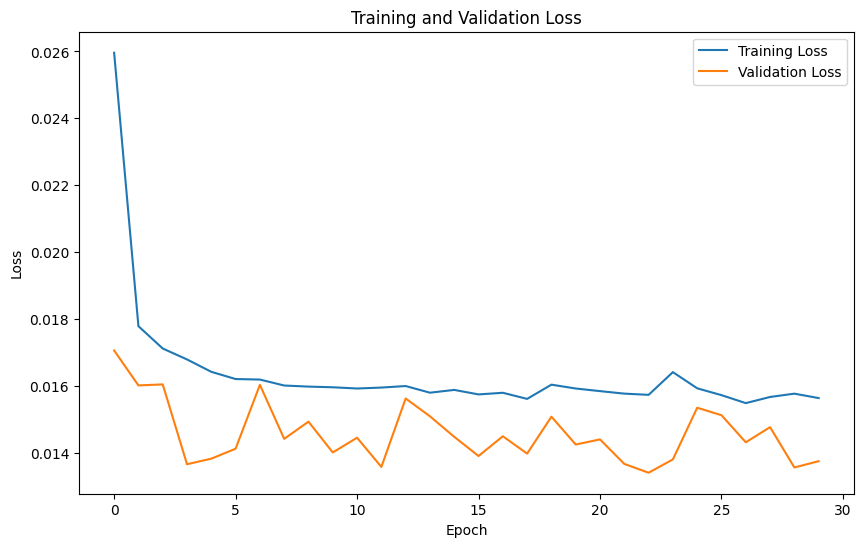

Test Loss: 0.0137
MAE: 23.5880
RMSE: 34.0878


In [ ]:
import torch.nn.functional as F
# 初始化模型
n_features = X_train.shape[2]
seq_length = X_train.shape[1]
model = WeatherTransformer(n_features, seq_length, d_model=64, d_ff=128, num_heads=2, n_layers=2)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output.squeeze(), y_batch)
                val_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    return train_losses, val_losses

# 执行训练
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# 保存 Transformer 模型
torch.save(model.state_dict(), 'transformer_model.pth')

In [ ]:

# 评估模型
def evaluate_model(model, test_loader, criterion, scaler, target_col_idx):
    model.eval()
    test_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            test_loss += loss.item()
            predictions.extend(output.squeeze().numpy())
            actuals.extend(y_batch.numpy())

    # 反标准化
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # 直接使用scaler的 scale_ 和 mean_
    predictions = predictions * scaler.scale_[target_col_idx] + scaler.mean_[target_col_idx]
    actuals = actuals * scaler.scale_[target_col_idx] + scaler.mean_[target_col_idx]


    # 计算评估指标
    mae = np.mean(np.abs(predictions - actuals))
    rmse = np.sqrt(np.mean((predictions - actuals)** 2))

    print(f'Test Loss: {test_loss / len(test_loader):.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')

    return predictions, actuals

# 执行评估
target_col_idx = all_cols.index(target_feature)
predictions, actuals = evaluate_model(model, test_loader, criterion, scaler, target_col_idx)

## 8.4 预测与可视化

In [ ]:
# 单样本预测函数
def predict_weather(model, input_data, scaler, all_cols, target_col_idx):
    model.eval()
    input_scaled = scaler.transform(input_data)
    input_tensor = torch.FloatTensor(input_scaled).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)

    prediction = output.item() * scaler.scale_[target_col_idx] + scaler.mean_[target_col_idx]


    return prediction

# 预测未来一小时温度
def predict_next_hour(model, df_scaled, scaler, all_cols, target_feature, seq_length=6):
    """使用最近seq_length小时数据预测下一小时"""
    # 提取最近seq_length小时数据
    last_seq = df_scaled.iloc[-seq_length:][all_cols].values
    prediction = predict_weather(model, last_seq, scaler, all_cols, all_cols.index(target_feature))
    return prediction

# 预测未来一小时温度
latest_data = df_scaled.tail(seq_length)
predicted_temp = predict_next_hour(model, latest_data, scaler, all_cols, target_feature)
print(f"预测下一小时温度: {predicted_temp:.2f} K ({predicted_temp - 273.15:.2f} °C)")

# 可视化预测结果
def visualize_predictions(predictions, actuals, num_samples=50):
    plt.figure(figsize=(12, 6))
    plt.plot(actuals[:num_samples], label='Actual')
    plt.plot(predictions[:num_samples], label='Predicted', linestyle='--')
    plt.xlabel('Sample')
    plt.ylabel(f'{target_var} (K)')
    plt.title(f'{target_var} Prediction vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

# 执行可视化
visualize_predictions(predictions, actuals)

# 九、Resnet训练

## 9.1 数据准备

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 数据路径
csv_path = '/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv'

# 变量映射
var_map = {
    'u10': 'u10',
    'v10': 'v10',
    't2m': 't2m',
    'z': 'z',
    'q': 'q',
    't': 't',
    'u': 'u',
    'v': 'v'
}

target_var = 't2m'
target_feature = var_map[target_var]
feature_vars = [var for var in var_map if var != target_var]
feature_cols = [var_map[var] for var in feature_vars]
all_cols = feature_cols + [target_feature]

# 读取数据
df = pd.read_csv(csv_path)
df['time'] = pd.to_datetime(df['time'])

# 标准化
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[all_cols])
df_scaled = pd.DataFrame(df_scaled, columns=all_cols)


## 9.2 构建序列

In [ ]:
def create_sequences(data, seq_length=6, pred_length=1):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length:i+seq_length+pred_length][target_feature].values)
    return np.array(X), np.array(y).squeeze()

X, y = create_sequences(df_scaled, seq_length=6, pred_length=1)


## 9.3 数据集划分 + DataLoader

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 变换为 Tensor，并调整维度用于 Conv1d
X_train = torch.FloatTensor(X_train).permute(0, 2, 1)  # [B, C, L]
X_val = torch.FloatTensor(X_val).permute(0, 2, 1)
X_test = torch.FloatTensor(X_test).permute(0, 2, 1)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)
y_test = torch.FloatTensor(y_test)

class WeatherDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = data.DataLoader(WeatherDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = data.DataLoader(WeatherDataset(X_val, y_val), batch_size=32)
test_loader = data.DataLoader(WeatherDataset(X_test, y_test), batch_size=32)


## 9.4 ResNet1D 模型定义

In [6]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)


In [7]:
class ResNet1D(nn.Module):
    def __init__(self, in_channels, num_blocks=3, hidden_channels=64):
        super(ResNet1D, self).__init__()
        layers = []
        for i in range(num_blocks):
            layers.append(
                ResNetBlock(
                    in_channels=in_channels if i == 0 else hidden_channels,
                    out_channels=hidden_channels
                )
            )
        self.resnet = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool1d(1)  # 全局平均池化
        self.fc = nn.Linear(hidden_channels, 1)  # 输出预测值

    def forward(self, x):
        x = self.resnet(x)             # [B, C, L]
        x = self.pool(x).squeeze(-1)   # [B, C] —— 压缩掉时间维
        x = self.fc(x)                 # [B, 1]
        return x


## 9.5 模型训练 & 验证

Epoch 5/30, Train Loss: 0.0100, Val Loss: 0.0083
Epoch 10/30, Train Loss: 0.0084, Val Loss: 0.0070
Epoch 15/30, Train Loss: 0.0077, Val Loss: 0.0066
Epoch 20/30, Train Loss: 0.0073, Val Loss: 0.0068
Epoch 25/30, Train Loss: 0.0069, Val Loss: 0.0064
Epoch 30/30, Train Loss: 0.0066, Val Loss: 0.0060


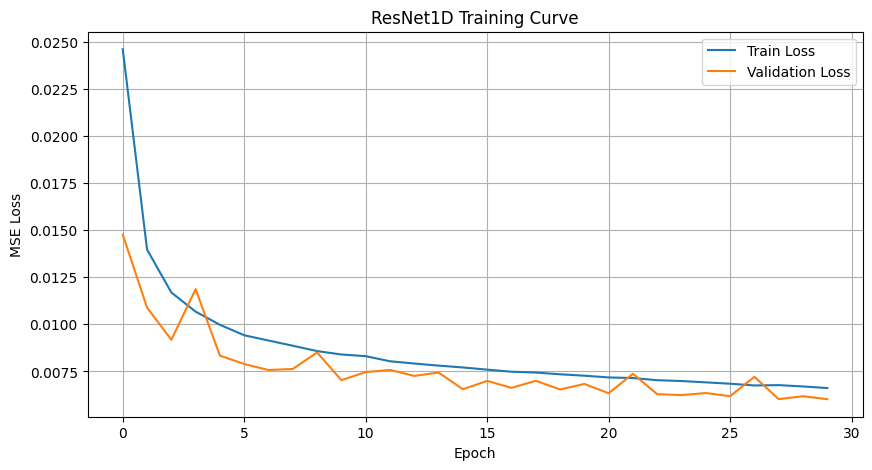

In [ ]:
# 模型初始化
resnet_model = ResNet1D(in_channels=X_train.shape[1])  # 特征数即通道数

# 损失函数 & 优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

train_losses, val_losses = train_model(
    resnet_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=30
)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("ResNet1D Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# 保存 ResNet 模型
torch.save(resnet_model.state_dict(), 'resnet_model.pth')

## 9.6 评估 & 可视化

In [ ]:
predictions, actuals = evaluate_model(
    resnet_model, test_loader, criterion, scaler, target_col_idx
)
visualize_predictions(predictions, actuals)

Test Loss: 0.0061
MAE: 0.6910
RMSE: 1.0305


# 十、LSTM

## 10.1 数据准备

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 数据路径
csv_path = '/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv'

# 变量映射
var_map = {
    'u10': 'u10',
    'v10': 'v10',
    't2m': 't2m',
    'z': 'z',
    'q': 'q',
    't': 't',
    'u': 'u',
    'v': 'v'
}

target_var = 't2m'
target_feature = var_map[target_var]
feature_vars = [var for var in var_map if var != target_var]
feature_cols = [var_map[var] for var in feature_vars]
all_cols = feature_cols + [target_feature]

# 读取数据
df = pd.read_csv(csv_path)
df['time'] = pd.to_datetime(df['time'])

# 标准化
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[all_cols])
df_scaled = pd.DataFrame(df_scaled, columns=all_cols)


## 10.2 构建序列

In [ ]:
def create_sequences(data, seq_length=6, pred_length=1):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length:i+seq_length+pred_length][target_feature].values)
    return np.array(X), np.array(y).squeeze()

X, y = create_sequences(df_scaled, seq_length=6, pred_length=1)


## 10.3 数据集划分

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = torch.FloatTensor(X_train)  # 保持原顺序 [B, L, C]
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)
y_test = torch.FloatTensor(y_test)

class WeatherDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = data.DataLoader(WeatherDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = data.DataLoader(WeatherDataset(X_val, y_val), batch_size=32)
test_loader = data.DataLoader(WeatherDataset(X_test, y_test), batch_size=32)


## 10.4 定义 LSTM 模型

In [8]:
class WeatherLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(WeatherLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)               # [batch, seq_len, hidden_dim]
        out = out[:, -1, :]                 # 取最后时间步的输出
        out = self.fc(out)                  # [batch, 1]
        return out


## 10.5 模型训练

In [ ]:
# 初始化
lstm_model = WeatherLSTM(input_dim=X_train.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)


Epoch 5/30, Train Loss: 0.0085, Val Loss: 0.0086
Epoch 10/30, Train Loss: 0.0069, Val Loss: 0.0071
Epoch 15/30, Train Loss: 0.0062, Val Loss: 0.0067
Epoch 20/30, Train Loss: 0.0058, Val Loss: 0.0069
Epoch 25/30, Train Loss: 0.0055, Val Loss: 0.0063
Epoch 30/30, Train Loss: 0.0052, Val Loss: 0.0063


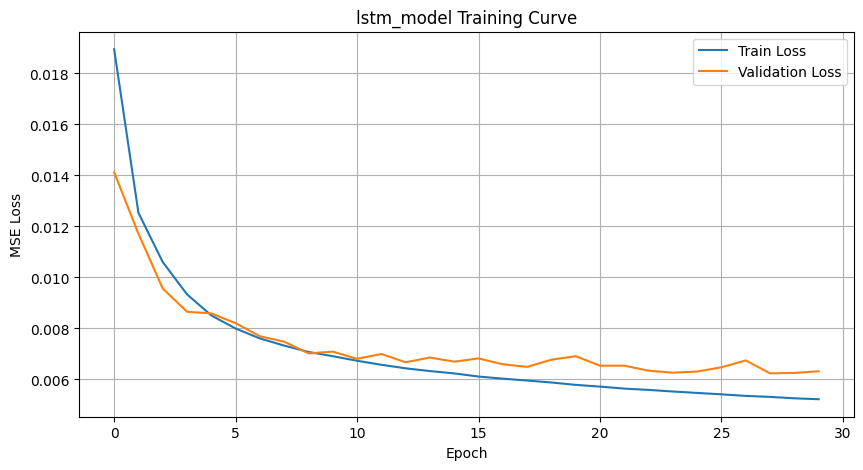

In [ ]:
train_losses, val_losses = train_model(
    lstm_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=30
)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("lstm_model Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
torch.save(lstm_model.state_dict(), 'lstm_model.pth')

## 10.6 评估 & 可视化

Test Loss: 0.0064
MAE: 0.7067
RMSE: 1.0589


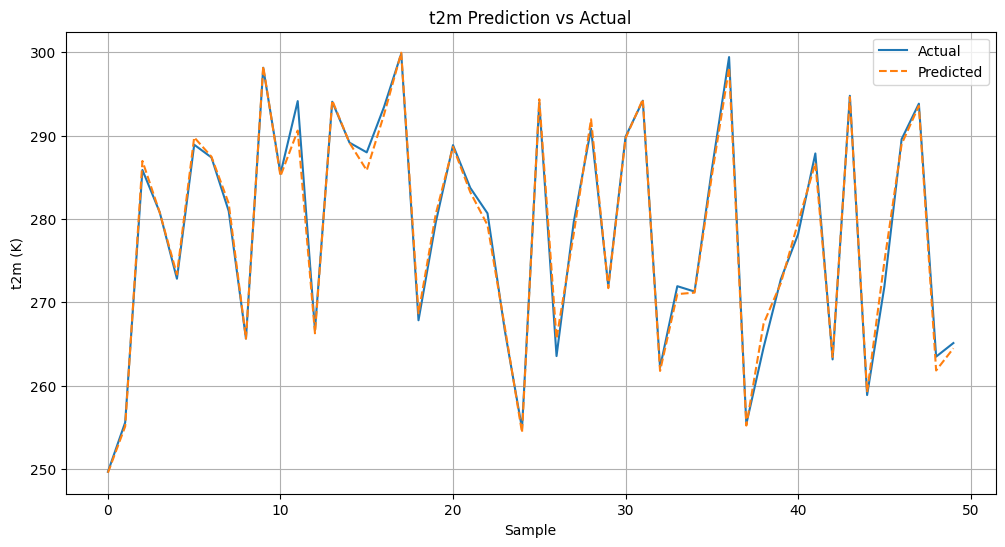

In [ ]:
lstm_predictions, lstm_actuals = evaluate_model(
    lstm_model,
    test_loader,
    criterion,
    scaler,
    target_col_idx
)

visualize_predictions(lstm_predictions, lstm_actuals)


# 十一、三种模型初步对比

## 11.1 加载模型

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import copy

# 加载 LSTM 模型
lstm_model = WeatherLSTM(input_dim=8)
lstm_model.load_state_dict(torch.load('/content/drive/MyDrive/model/lstm_model.pth'))
lstm_model.eval()

# 加载 Transformer 模型
transformer_model = WeatherTransformer(
    n_features=8,
    seq_length=6,
    d_model=64,        # 必须是64
    d_ff=128,          # 必须是128
    num_heads=2,
    n_layers=2
)

transformer_model.load_state_dict(torch.load('/content/drive/MyDrive/model/transformer_model.pth'))
transformer_model.eval()

# 加载 Resnet 模型
resnet_model = ResNet1D(in_channels=8)
resnet_model.load_state_dict(torch.load('/content/drive/MyDrive/model/resnet_model.pth'))
resnet_model.eval()


ResNet1D(
  (resnet): Sequential(
    (0): ResNetBlock(
      (conv1): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResNetBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcu

In [ ]:
from datetime import timedelta

def predict_all_models_at_time(models_dict, df, scaler, all_cols, feature_cols, target_feature, time_str, seq_length=8):
    target_time = pd.Timestamp(time_str)
    start_time = target_time - timedelta(hours=seq_length)

    # 提取数据片段
    seq_df = df[(df['time'] >= start_time) & (df['time'] < target_time)].copy()
    if len(seq_df) < seq_length:
        raise ValueError(f" 数据不足，无法预测 {target_time}")

    # 标准化（包含所有列）
    input_all = scaler.transform(seq_df[all_cols])

    # 结果容器
    predictions = {}

    for name, model in models_dict.items():
        model.eval()
        with torch.no_grad():
            # 获取模型期望输入特征数
            if hasattr(model, 'lstm'):
                expected_dim = model.lstm.input_size
                model_type = 'lstm'
            elif hasattr(model, 'embedding'):
                expected_dim = model.embedding.in_features
                model_type = 'transformer'
            elif isinstance(model, ResNet1D):
                expected_dim = model.resnet[0].conv1.in_channels
                model_type = 'resnet'
            else:
                raise ValueError(f"未知模型类型: {name}")

            # 补齐特征列
            actual_feature_cols = feature_cols[:expected_dim]
            if len(actual_feature_cols) < expected_dim:
                remaining = [col for col in all_cols if col not in actual_feature_cols and col != target_feature]
                actual_feature_cols += remaining[:expected_dim - len(actual_feature_cols)]

            feat_idx = [all_cols.index(col) for col in actual_feature_cols]
            input_scaled = input_all[:, feat_idx]

            # 构造张量格式
            if model_type == 'lstm' or model_type == 'transformer':
                input_tensor = torch.FloatTensor(input_scaled).unsqueeze(0)  # [1, seq_len, features]
            elif model_type == 'resnet':
                input_tensor = torch.FloatTensor(input_scaled.T).unsqueeze(0)  # [1, features, seq_len]

            # 模型预测
            output = model(input_tensor)
            pred_value = output.item() * scaler.scale_[all_cols.index(target_feature)] + scaler.mean_[all_cols.index(target_feature)]
            predictions[name] = pred_value

    # 打印预测
    print(f"\n 预测时间点：{time_str}")
    for model_name, value in predictions.items():
        print(f"{model_name:12s}: {value:.2f} K ({value - 273.15:.2f} °C)")

    # 可视化
    plt.figure(figsize=(7, 5))
    plt.bar(predictions.keys(), [v - 273.15 for v in predictions.values()])
    plt.ylabel("Predicted Temperature (°C)")
    plt.title(f"Model Prediction Comparison @ {time_str}")
    plt.grid(axis='y')
    plt.show()

    return predictions


**打印期望特征数**

In [ ]:
print("Transformer expects n_features =", transformer_model.embedding.in_features)
print("ResNet expects n_features =", resnet_model.resnet[0].conv1.in_channels)
print("LSTM expects n_features =", lstm_model.lstm.input_size)

Transformer expects n_features = 8
ResNet expects n_features = 8
LSTM expects n_features = 8


## 11.2 具体时间点预测

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 数据路径
csv_path = '/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv'

# 变量映射
var_map = {
    'u10': 'u10',
    'v10': 'v10',
    't2m': 't2m',
    'z': 'z',
    'q': 'q',
    't': 't',
    'u': 'u',
    'v': 'v'
}

target_var = 't2m'
target_feature = var_map[target_var]
feature_vars = [var for var in var_map if var != target_var]
feature_cols = [var_map[var] for var in feature_vars]
all_cols = feature_cols + [target_feature]

# 读取数据
df = pd.read_csv(csv_path)
df['time'] = pd.to_datetime(df['time'])

# 标准化
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[all_cols])
df_scaled = pd.DataFrame(df_scaled, columns=all_cols)


 预测时间点：2016-09-01 09:00
LSTM        : 289.92 K (16.77 °C)
Transformer : 292.19 K (19.04 °C)
ResNet      : 286.90 K (13.75 °C)


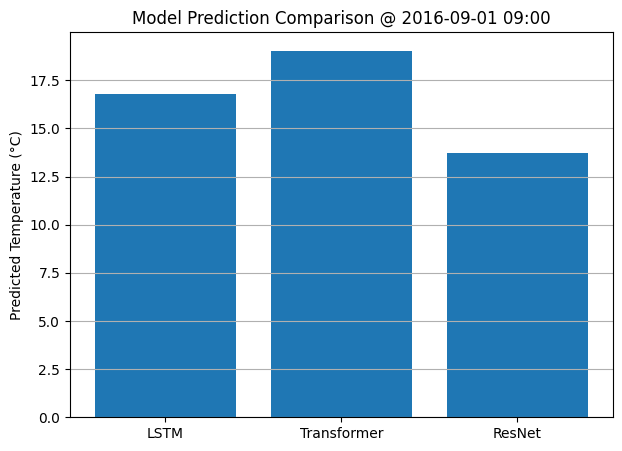

{'LSTM': np.float64(289.92004251225296),
 'Transformer': np.float64(292.1866396517226),
 'ResNet': np.float64(286.8963048257321)}

In [ ]:

models = {
    "LSTM": lstm_model,
    "Transformer": transformer_model,
    "ResNet": resnet_model
}

predict_all_models_at_time(
    models_dict=models,
    df=df,
    scaler=scaler,
    all_cols=all_cols,
    feature_cols = ['u10', 'v10', 'z', 'q', 't', 'u', 'v', 't2m'],
    target_feature=target_feature,
    time_str='2016-09-01 09:00',
    seq_length=8
)


In [ ]:
import pandas as pd

# 真实温度
df = pd.read_csv('/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv')
df['time'] = pd.to_datetime(df['time'])

# 查找 2016-09-01 09:00 的记录
actual_value = df[df['time'] == '2016-09-01 09:00']['t2m'].values[0]
print(f"实际气温（t2m）为：{actual_value} K （{actual_value - 273.15:.2f} °C）")


实际气温（t2m）为：289.28403 K （16.13 °C）


## 11.3 评估函数对比

**为 ResNet 单独创建 test_loader_resnet，并做 .permute(0, 2, 1)**

In [ ]:
X_test_resnet = X_test.permute(0, 2, 1)  # [B, features, seq_len]
test_loader_resnet = data.DataLoader(WeatherDataset(X_test_resnet, y_test), batch_size=32)


**构建模型-数据映射表**

In [ ]:
model_loader_map = {
    'LSTM': (lstm_model, test_loader),                      # [B, L, C]
    'Transformer': (transformer_model, test_loader),        # [B, L, C]
    'ResNet': (resnet_model, test_loader_resnet)            # [B, C, L]
}


In [ ]:
import seaborn as sns

def evaluate_and_compare_models(models_dict, scaler, all_cols, target_feature, criterion):
    results = []

    for name, (model, loader) in models_dict.items():
        model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for X_batch, y_batch in loader:
                output = model(X_batch).squeeze()
                predictions.extend(output.numpy())
                actuals.extend(y_batch.numpy())

        predictions = np.array(predictions)
        actuals = np.array(actuals)

        # 反标准化
        target_idx = all_cols.index(target_feature)
        predictions = predictions * scaler.scale_[target_idx] + scaler.mean_[target_idx]
        actuals = actuals * scaler.scale_[target_idx] + scaler.mean_[target_idx]

        # 指标计算
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        rmse = np.sqrt(mse)

        results.append({
            'Model': name,
            'MAE': mae,
            'RMSE': rmse,
            'MSE': mse
        })

    df = pd.DataFrame(results).sort_values(by='RMSE')

    print("\n Model Evaluation Summary:")
    print(df.to_string(index=False))

    #  Visualization: Bar chart
    plt.figure(figsize=(12, 6))
    df_melted = df.melt(id_vars='Model', value_vars=['MAE', 'RMSE', 'MSE'])

    bar = sns.barplot(data=df_melted, x='Model', y='value', hue='variable')
    bar.set_ylabel("Error (K)")
    bar.set_title("Model Evaluation Comparison (MAE vs RMSE vs MSE)")
    plt.grid(True, axis='y')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

    return df



 Model Evaluation Summary:
      Model      MAE     RMSE      MSE
     ResNet 0.690979 1.030499 1.061928
       LSTM 0.706690 1.058897 1.121263
Transformer 1.073363 1.551150 2.406065


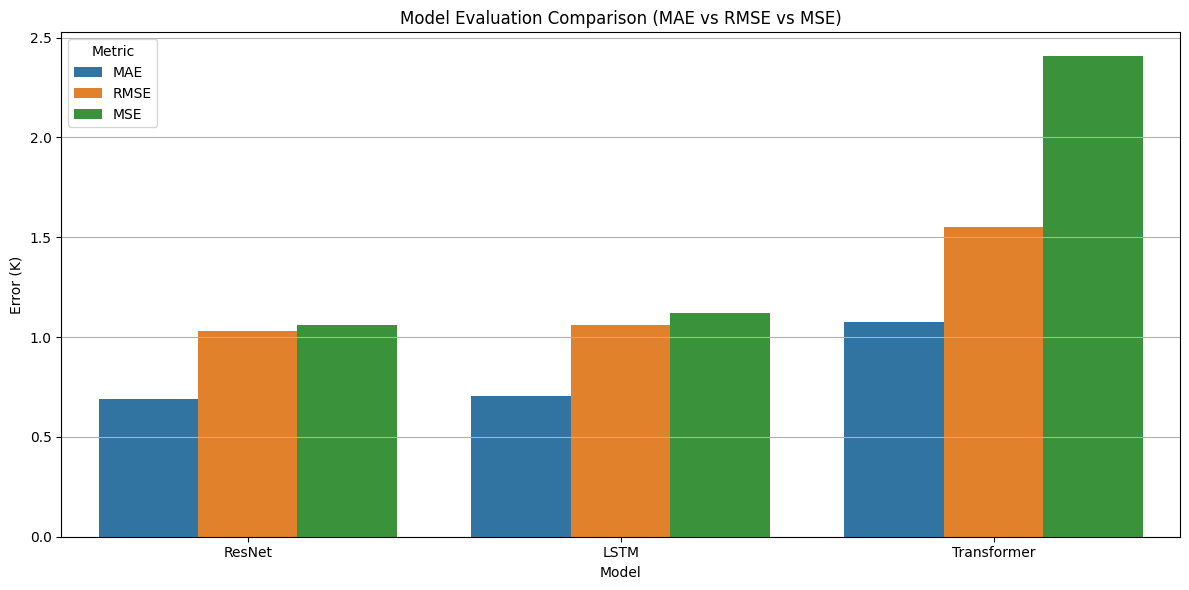

,Model,MAE,RMSE,MSE
2,ResNet,0.690979,1.030499,1.061928
0,LSTM,0.706690,1.058897,1.121263
1,Transformer,1.073363,1.551150,2.406065


In [ ]:
models = {
    'LSTM': lstm_model,
    'Transformer': transformer_model,
    'ResNet': resnet_model
}

evaluate_and_compare_models(
    models_dict=model_loader_map,
    scaler=scaler,
    all_cols=all_cols,
    target_feature=target_feature,
    criterion=nn.MSELoss()
)


## 11.4 模型预测 vs 实际值趋势图

In [9]:
def plot_prediction_trends(predictions_dict, actuals, num_points=100):
    plt.figure(figsize=(14, 6))

    # 画每个模型的预测曲线
    for model_name, preds in predictions_dict.items():
        plt.plot(preds[:num_points], label=f'{model_name} Prediction', linestyle='--')

    # 实际值
    plt.plot(actuals[:num_points], label='Actual', linewidth=2, color='black')

    plt.title(f"Model Predictions vs Actuals (First {num_points} Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("t2m (K)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


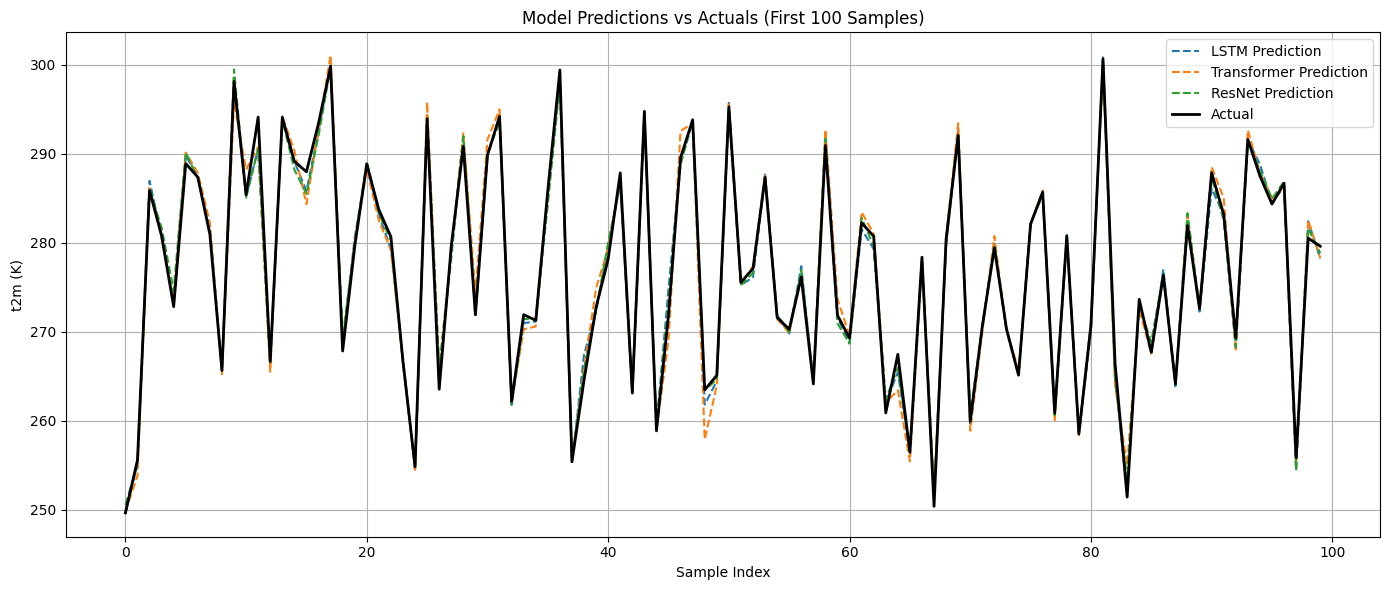

In [ ]:
# 生成每个模型的预测和真实值
predictions_dict = {}
for name, (model, loader) in model_loader_map.items():
    model.eval()
    preds, acts = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            output = model(X_batch).squeeze()
            preds.extend(output.numpy())
            acts.extend(y_batch.numpy())
    # 反标准化
    preds = np.array(preds) * scaler.scale_[target_col_idx] + scaler.mean_[target_col_idx]
    acts = np.array(acts) * scaler.scale_[target_col_idx] + scaler.mean_[target_col_idx]
    predictions_dict[name] = preds

# 抽一组实际值用于对比
actuals = acts

# 画趋势图
plot_prediction_trends(predictions_dict, actuals, num_points=100)


## 11.5 模型误差分布图（残差图）

In [ ]:
def plot_residuals(predictions_dict, actuals, bins=30):
    plt.figure(figsize=(14, 5))

    for name, preds in predictions_dict.items():
        residuals = preds - actuals
        sns.histplot(residuals, bins=bins, kde=True, label=name, stat='density', element='step')

    plt.title("Residual (Prediction - Actual) Distribution")
    plt.xlabel("Residual (K)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


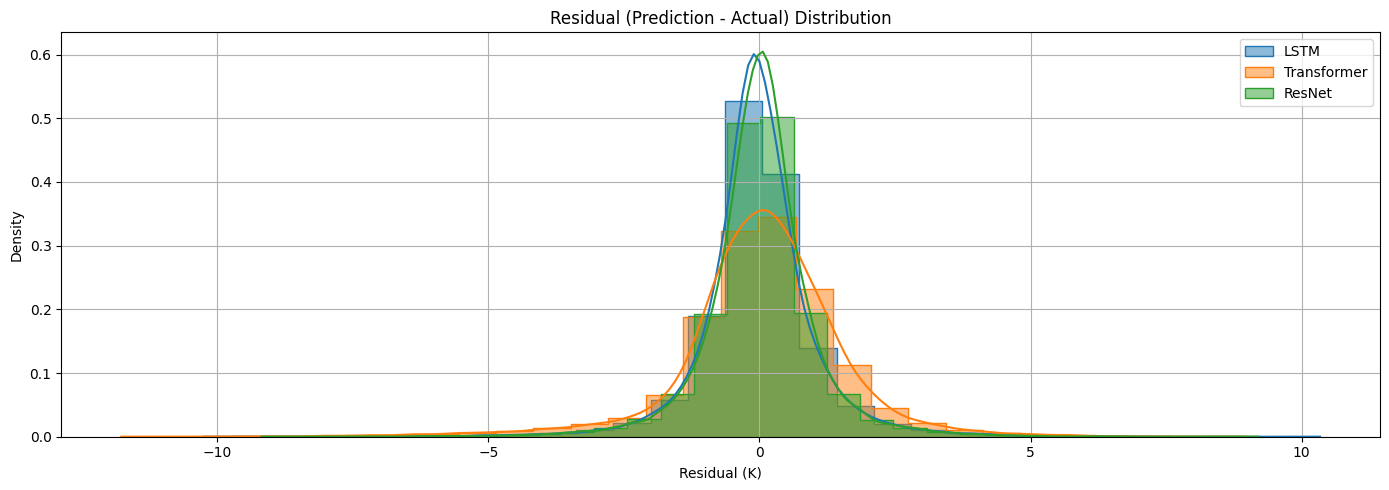

In [ ]:
plot_residuals(predictions_dict, actuals)


## 11.6 一日内预测温度对比

In [ ]:
import pandas as pd

# 真实温度
df = pd.read_csv('/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv')
df['time'] = pd.to_datetime(df['time'])

# 查找 2016-09-01 09:00 的记录
actual_value = df[df['time'] == '2016-09-01 09:00']['t2m'].values[0]
print(f"实际气温（t2m）为：{actual_value} K （{actual_value - 273.15:.2f} °C）")


实际气温（t2m）为：289.28403 K （16.13 °C）


In [10]:
def plot_daily_prediction_comparison(models_dict, df, scaler, all_cols, feature_cols, target_feature, date_str, seq_length=6):
    date = pd.to_datetime(date_str)
    hours = pd.date_range(start=date, periods=24, freq='h')  #  小写 h，避免警告

    valid_hours = []
    actuals = []
    results = {name: [] for name in models_dict}

    for hour in hours:
        try:
            actual_row = df[df['time'] == hour]
            if actual_row.empty:
                raise ValueError("No actual data")
            actuals.append(actual_row[target_feature].values[0])
            valid_hours.append(hour)

            for name, model in models_dict.items():
              try:
                  # 获取模型期望特征维度
                  if hasattr(model, 'lstm'):
                      expected_dim = model.lstm.input_size
                  elif hasattr(model, 'embedding'):
                      expected_dim = model.embedding.in_features
                  elif hasattr(model, 'resnet'):
                      expected_dim = model.resnet[0].conv1.in_channels
                  else:
                      raise ValueError(f"{name} is not a supported model.")

                  # 补齐/裁剪特征列
                  actual_feature_cols = feature_cols[:expected_dim]
                  if len(actual_feature_cols) < expected_dim:
                      remaining = [col for col in all_cols if col not in actual_feature_cols and col != target_feature]
                      actual_feature_cols += remaining[:expected_dim - len(actual_feature_cols)]
                  feat_idx = [all_cols.index(col) for col in actual_feature_cols]

                  # 提取输入数据
                  input_all = scaler.transform(df[(df['time'] >= hour - timedelta(hours=seq_length)) & (df['time'] < hour)][all_cols])
                  input_scaled = input_all[:, feat_idx]

                  # 构造张量
                  if hasattr(model, 'lstm') or hasattr(model, 'embedding'):
                      input_tensor = torch.FloatTensor(input_scaled).unsqueeze(0)  # [1, seq_len, features]
                  elif hasattr(model, 'resnet'):
                      input_tensor = torch.FloatTensor(input_scaled.T).unsqueeze(0)  # [1, features, seq_len]

                  #  模型预测
                  model.eval()
                  with torch.no_grad():
                      output = model(input_tensor)
                      pred = output.item() * scaler.scale_[all_cols.index(target_feature)] + scaler.mean_[all_cols.index(target_feature)]

                  results[name].append(pred)

              except Exception as e:
                  print(f"Skipped {hour} for {name}: {e}")
                  results[name].append(np.nan)


        except Exception as e:
            print(f" Skipped {hour} (outer): {e}")
            for name in results:
                results[name].append(np.nan)
            actuals.append(np.nan)
            continue

    # 绘图
    plt.figure(figsize=(14, 6))
    plt.plot(valid_hours, actuals, label='Actual', color='black', linewidth=2)

    for name, preds in results.items():
        plt.plot(valid_hours, preds, label=name + ' Prediction', linestyle='--')

    plt.title(f"Hourly t2m Prediction Comparison on {date_str}")
    plt.xlabel("Hour")
    plt.ylabel("t2m (K)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


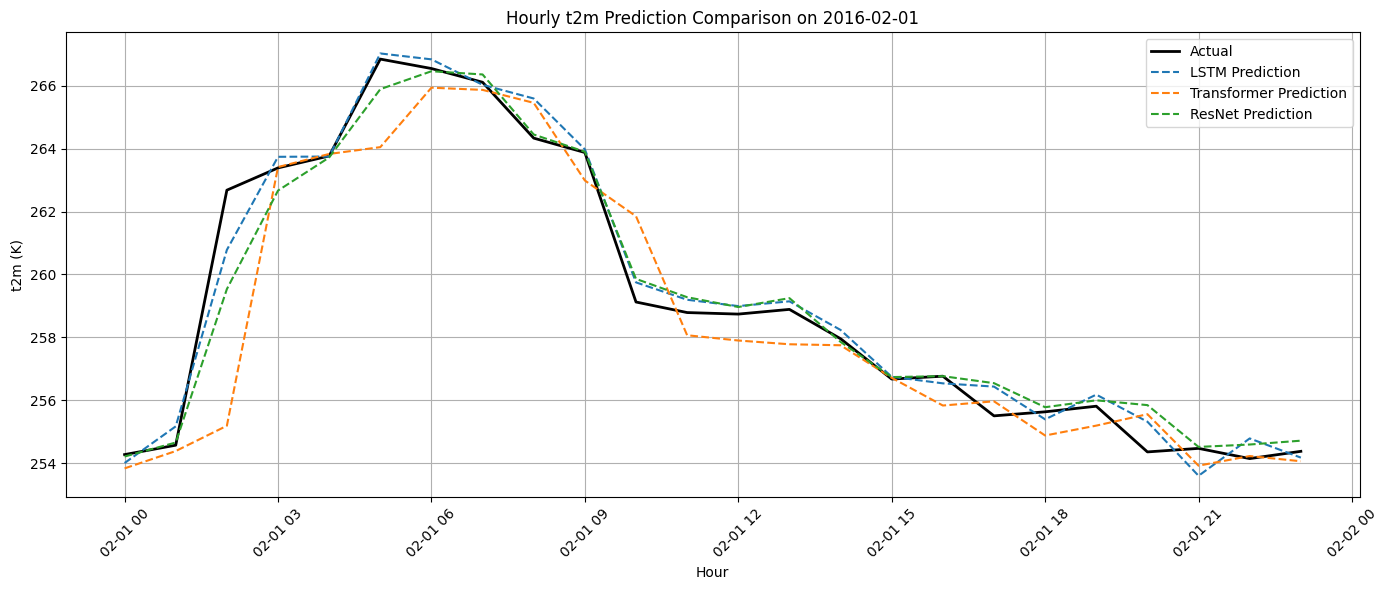

In [23]:
from datetime import timedelta
models = {
    "LSTM": lstm_model,
    "Transformer": transformer_model,
    "ResNet": resnet_model
}

plot_daily_prediction_comparison(
    models_dict=models,
    df=df,
    scaler=scaler,
    all_cols=all_cols,
    feature_cols = ['u10', 'v10', 'z', 'q', 't', 'u', 'v', 't2m'],
    target_feature=target_feature,
    date_str='2016-02-01',
    seq_length=6  # 小时窗口
)


# 十二、优化Transformer：辅助上下文和周期性特征编码

## 12.1 数据准备

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
import math
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# 数据文件路径
csv_path = '/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv'



# 根据实际列名调整变量映射
var_map = {
    'u10': 'u10',
    'v10': 'v10',
    't2m': 't2m',
    'z': 'z',
    'q': 'q',
    't': 't',
    'u': 'u',
    'v': 'v',
    'hour_sin': 'hour_sin',
    'hour_cos': 'hour_cos',
    'month_sin': 'month_sin',
    'month_cos': 'month_cos'
}

# 目标变量
target_var = 't2m'
target_feature = var_map[target_var]

# 选择特征变量（排除目标变量）
feature_vars = [var for var in var_map if var != target_var]
feature_cols = [var_map[var] for var in feature_vars]
all_cols = feature_cols + [target_feature]

# 加载数据
df = pd.read_csv(csv_path)
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df.drop(columns=['hour', 'month'], inplace=True)

# 数据标准化
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[all_cols])
df_scaled = pd.DataFrame(df_scaled, columns=all_cols)

# 构建时间序列数据
def create_sequences(data, seq_length=6, pred_length=1):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length:i+seq_length+pred_length][target_feature].values)
    return np.array(X), np.array(y).squeeze()

X, y = create_sequences(df_scaled, seq_length=6, pred_length=1)

# 划分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 转换为PyTorch张量
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# 创建数据加载器
class WeatherDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = WeatherDataset(X_train, y_train)
val_dataset = WeatherDataset(X_val, y_val)
test_dataset = WeatherDataset(X_test, y_test)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32)
test_loader = data.DataLoader(test_dataset, batch_size=32)

## 12.2 模型训练

In [5]:
# 自注意力机制
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.linears = nn.ModuleList([copy.deepcopy(nn.Linear(d_model, d_model)) for _ in range(3)])

    def attention(self, query, key, value, mask=None):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        return torch.matmul(p_attn, value), p_attn

    def forward(self, query, key, value, mask=None):
        nbatches = query.size(0)
        query, key, value = [l(x).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
                            for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = self.attention(query, key, value, mask=mask)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)
        return x

# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# 前馈神经网络
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# 编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# 气象专用Transformer模型
class WeatherTransformer(nn.Module):
    def __init__(self, n_features, seq_length, d_model=128, d_ff=256, num_heads=4, n_layers=2, dropout=0.1):
        super(WeatherTransformer, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length
        self.embedding = nn.Linear(n_features, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(
                d_model,
                MultiHeadAttention(d_model, num_heads),
                FeedForward(d_model, d_ff, dropout),
                dropout
            ) for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.final_layer = nn.Linear(d_model, 1)

    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x, mask)
        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.final_layer(x)
        return x

Epoch 5/30, Train Loss: 0.0099, Val Loss: 0.0092
Epoch 10/30, Train Loss: 0.0093, Val Loss: 0.0094
Epoch 15/30, Train Loss: 0.0086, Val Loss: 0.0108
Epoch 20/30, Train Loss: 0.0087, Val Loss: 0.0078
Epoch 25/30, Train Loss: 0.0084, Val Loss: 0.0074
Epoch 30/30, Train Loss: 0.0083, Val Loss: 0.0087


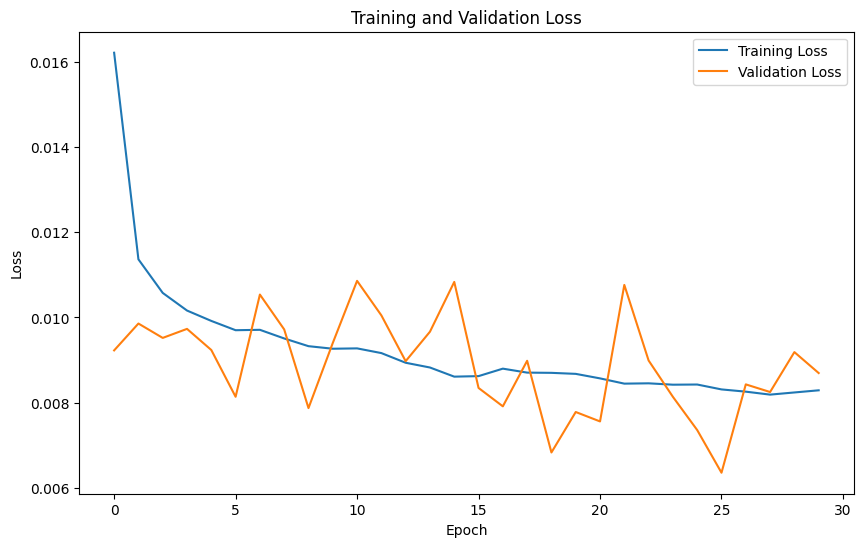

In [ ]:
import torch.nn.functional as F
# 初始化模型
n_features = X_train.shape[2]
seq_length = X_train.shape[1]
model = WeatherTransformer(n_features, seq_length, d_model=64, d_ff=128, num_heads=2, n_layers=2)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output.squeeze(), y_batch)
                val_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    return train_losses, val_losses

# 执行训练
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# 保存 Transformer 模型
torch.save(model.state_dict(), 'new_transformer_model.pth')

## 12.3 评估&可视化

In [ ]:
# 加载优化模型
model.load_state_dict(torch.load('new_transformer_model.pth'))

# 执行评估和可视化
preds, actuals = evaluate_and_plot_model(
    model=model,
    test_loader=test_loader,
    scaler=scaler,
    all_cols=all_cols,
    target_feature=target_feature,
    model_name="Transformer"
)


In [ ]:

# 评估模型
def evaluate_model(model, test_loader, criterion, scaler, target_col_idx):
    model.eval()
    test_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            test_loss += loss.item()
            predictions.extend(output.squeeze().numpy())
            actuals.extend(y_batch.numpy())

    # 反标准化
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # 直接使用scaler的 scale_ 和 mean_
    predictions = predictions * scaler.scale_[target_col_idx] + scaler.mean_[target_col_idx]
    actuals = actuals * scaler.scale_[target_col_idx] + scaler.mean_[target_col_idx]


    # 计算评估指标
    mae = np.mean(np.abs(predictions - actuals))
    rmse = np.sqrt(np.mean((predictions - actuals)** 2))

    print(f'Test Loss: {test_loss / len(test_loader):.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')

    return predictions, actuals

# 执行评估
target_col_idx = all_cols.index(target_feature)
predictions, actuals = evaluate_model(model, test_loader, criterion, scaler, target_col_idx)

Test Loss: 0.0087
MAE: 0.9174
RMSE: 1.2349


# 十三、统一时间列后重新训练ResNet和LSTM

## 13.1 ResNet

### 13.1.1 数据准备

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 数据路径
csv_path = '/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv'

# 根据实际列名调整变量映射
var_map = {
    'u10': 'u10',
    'v10': 'v10',
    't2m': 't2m',
    'z': 'z',
    'q': 'q',
    't': 't',
    'u': 'u',
    'v': 'v',
    'hour_sin': 'hour_sin',
    'hour_cos': 'hour_cos',
    'month_sin': 'month_sin',
    'month_cos': 'month_cos'
}

# 目标变量
target_var = 't2m'
target_feature = var_map[target_var]

# 选择特征变量（排除目标变量）
feature_vars = [var for var in var_map if var != target_var]
feature_cols = [var_map[var] for var in feature_vars]
all_cols = feature_cols + [target_feature]

# 加载数据
df = pd.read_csv(csv_path)
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df.drop(columns=['hour', 'month'], inplace=True)

# 标准化
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[all_cols])
df_scaled = pd.DataFrame(df_scaled, columns=all_cols)


def create_sequences(data, seq_length=6, pred_length=1):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length:i+seq_length+pred_length][target_feature].values)
    return np.array(X), np.array(y).squeeze()

X, y = create_sequences(df_scaled, seq_length=6, pred_length=1)

# 不做 permute，先保留原格式用于 LSTM/Transformer
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

# 拆分训练集/验证集/测试集（按原序列维度）
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(X_temp_raw, y_temp, test_size=0.5, random_state=42)

#  1. 给 LSTM / Transformer 用的数据（保持 [B, L, C]）
X_train_ltc = X_train_raw
X_val_ltc = X_val_raw
X_test_ltc = X_test_raw

#  2. 给 ResNet 用的数据（转换为 [B, C, L]）
X_train_resnet = X_train_raw.permute(0, 2, 1)
X_val_resnet = X_val_raw.permute(0, 2, 1)
X_test_resnet = X_test_raw.permute(0, 2, 1)


class WeatherDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader_resnet = data.DataLoader(WeatherDataset(X_train_resnet, y_train), batch_size=32, shuffle=True)
val_loader_resnet = data.DataLoader(WeatherDataset(X_val_resnet, y_val), batch_size=32)
test_loader_resnet = data.DataLoader(WeatherDataset(X_test_resnet, y_test), batch_size=32)





### 13.1.2 模型定义与训练

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)


Epoch 5/30, Train Loss: 0.0052, Val Loss: 0.0048
Epoch 10/30, Train Loss: 0.0043, Val Loss: 0.0040
Epoch 15/30, Train Loss: 0.0039, Val Loss: 0.0036
Epoch 20/30, Train Loss: 0.0037, Val Loss: 0.0038
Epoch 25/30, Train Loss: 0.0036, Val Loss: 0.0035
Epoch 30/30, Train Loss: 0.0035, Val Loss: 0.0034


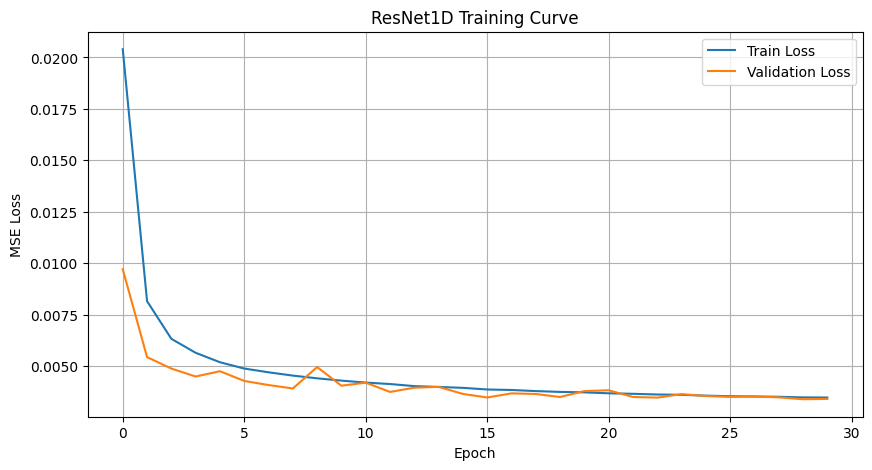

In [ ]:
# 模型初始化
resnet_model_new = ResNet1D(in_channels=X_train.shape[2])   # 特征数即通道数

# 损失函数 & 优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(resnet_model_new.parameters(), lr=0.001)

train_losses, val_losses = train_model(
    resnet_model_new,
    train_loader_resnet,
    val_loader_resnet,
    criterion,
    optimizer,
    epochs=30
)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("ResNet1D Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
torch.save(resnet_model_new.state_dict(), '/content/drive/MyDrive/model/resnet_model_new.pth')

### 12.1.3 评估 & 可视化


 ResNet_new 评估结果：
MAE: 0.538 | RMSE: 0.784 | MSE: 0.614


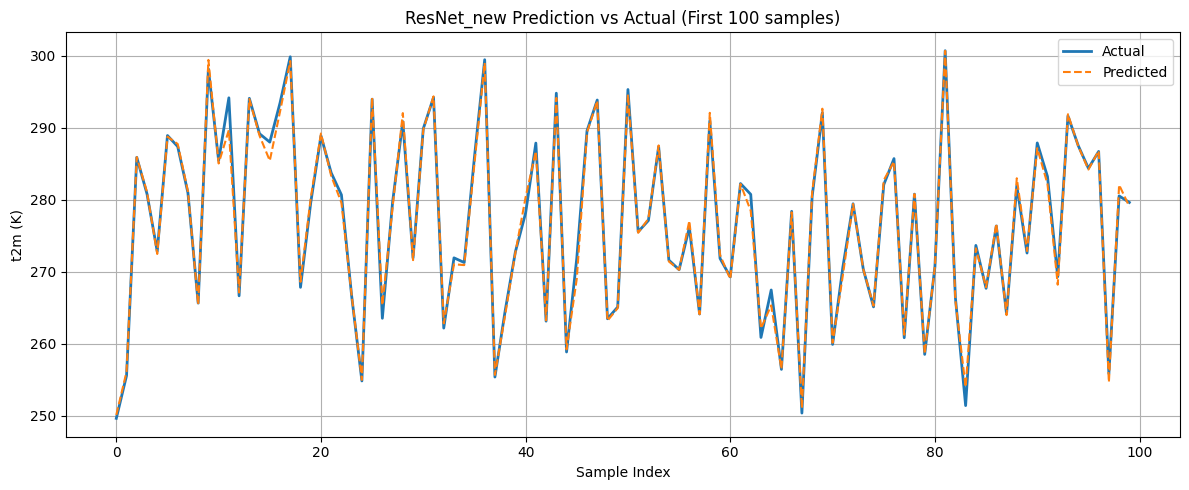

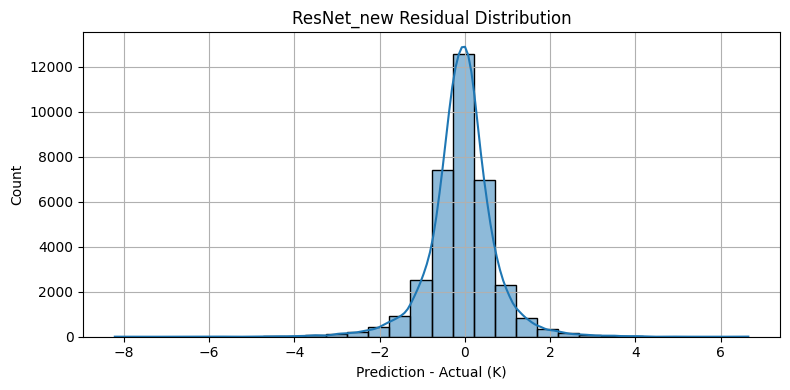

In [ ]:
# 执行评估和可视化
preds, actuals = evaluate_and_plot_model(
    model=resnet_model_new,
    test_loader=test_loader_resnet,
    scaler=scaler,
    all_cols=all_cols,
    target_feature=target_feature,
    model_name="ResNet_new"
)


## 13.2 LSTM

### 13.2.1 数据准备

In [ ]:
train_loader_lstm = data.DataLoader(WeatherDataset(X_train_ltc, y_train), batch_size=32, shuffle=True)
val_loader_lstm = data.DataLoader(WeatherDataset(X_val_ltc, y_val), batch_size=32)
test_loader_lstm = data.DataLoader(WeatherDataset(X_test_ltc, y_test), batch_size=32)




### 13.2.2 模型定义与训练

In [ ]:
class WeatherLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(WeatherLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)               # [batch, seq_len, hidden_dim]
        out = out[:, -1, :]                 # 取最后时间步的输出
        out = self.fc(out)                  # [batch, 1]
        return out


In [ ]:
# 初始化
lstm_model_new = WeatherLSTM(input_dim=X_train.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model_new.parameters(), lr=0.001)



Epoch 5/30, Train Loss: 0.0042, Val Loss: 0.0043
Epoch 10/30, Train Loss: 0.0036, Val Loss: 0.0037
Epoch 15/30, Train Loss: 0.0033, Val Loss: 0.0036
Epoch 20/30, Train Loss: 0.0031, Val Loss: 0.0034
Epoch 25/30, Train Loss: 0.0030, Val Loss: 0.0034
Epoch 30/30, Train Loss: 0.0028, Val Loss: 0.0033


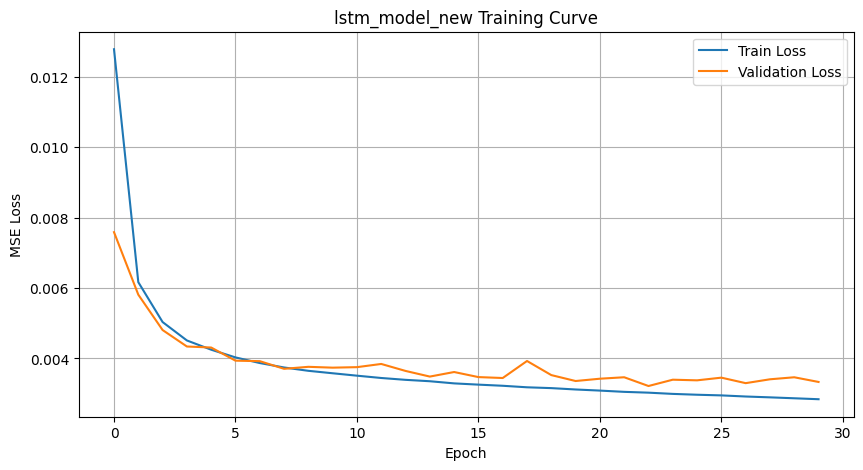

In [ ]:
train_losses, val_losses = train_model(
    lstm_model_new,
    train_loader_lstm,
    val_loader_lstm,
    criterion,
    optimizer,
    epochs=30
)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("lstm_model_new Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
torch.save(lstm_model_new.state_dict(), 'lstm_model_new.pth')

### 13.2.3 评估&可视化

Test Loss: 0.0034
MAE: 0.5242
RMSE: 0.7725


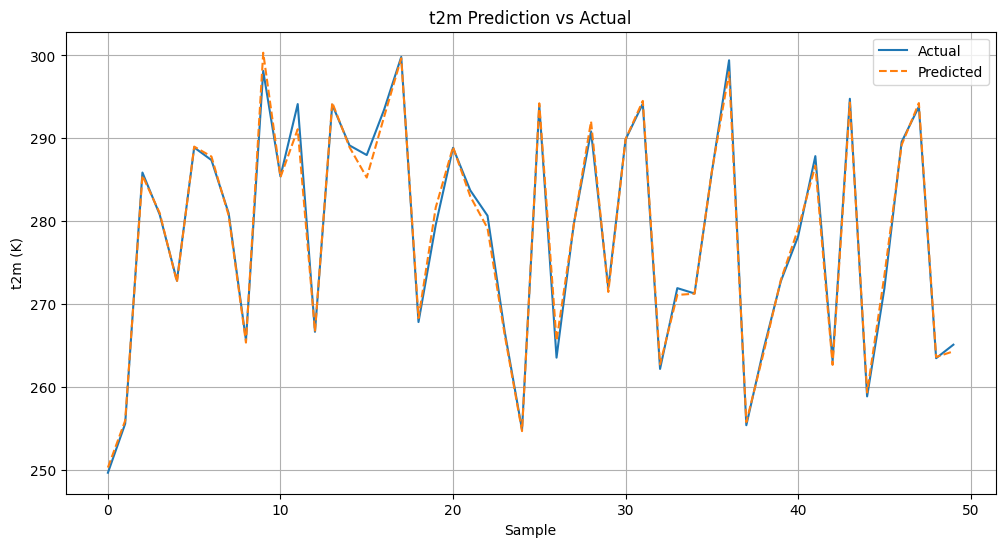

In [ ]:
lstm_predictions, lstm_actuals = evaluate_model(
    lstm_model_new,
    test_loader_lstm,
    criterion,
    scaler,
    target_col_idx
)

visualize_predictions(lstm_predictions, lstm_actuals)


# 十四、优化后对比

## 14.1 加载模型

In [9]:
import torch

# Transformer 模型加载（新版，特征数为12）
transformer_model_new = WeatherTransformer(
    n_features=12,
    seq_length=6,
    d_model=64,
    d_ff=128,
    num_heads=2,
    n_layers=2
)
transformer_model_new.load_state_dict(torch.load('/content/drive/MyDrive/model/transformer_model_new.pth'))
transformer_model_new.eval()

# ResNet 模型加载（新版）
resnet_model_new = ResNet1D(in_channels=12)
resnet_model_new.load_state_dict(torch.load('/content/drive/MyDrive/model/resnet_model_new.pth'))
resnet_model_new.eval()

# LSTM 模型加载（新版）
lstm_model_new = WeatherLSTM(input_dim=12)
lstm_model_new.load_state_dict(torch.load('/content/drive/MyDrive/model/lstm_model_new.pth'))
lstm_model_new.eval()


WeatherLSTM(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

## 14.2 具体时间点

In [ ]:
models_dict = {
    "LSTM": {
        "model": lstm_model,
        "features": ['u10', 'v10', 'z', 'q', 't', 'u', 'v', 't2m']
    },
    "Transformer": {
        "model": transformer_model,
        "features": ['u10', 'v10', 'z', 'q', 't', 'u', 'v', 't2m']
    },
    "ResNet": {
        "model": resnet_model,
        "features": ['u10', 'v10', 'z', 'q', 't', 'u', 'v', 't2m']
    },
    'LSTM_new': {
        'model': lstm_model_new,
        'features': ['u10', 'v10', 'z', 'q', 't', 'u', 'v', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 't2m']
    },
    'Transformer_new': {
        'model': transformer_model_new,
        'features': ['u10', 'v10', 'z', 'q', 't', 'u', 'v', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 't2m']
    },
    'ResNet_new': {
        'model': resnet_model_new,
        'features': ['u10', 'v10', 'z', 'q', 't', 'u', 'v', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 't2m']
    }
}


In [ ]:
from datetime import timedelta
import torch
import matplotlib.pyplot as plt

def predict_all_models_at_time_new(models_dict, df, scaler, all_cols, target_feature, time_str, seq_length=8):
    target_time = pd.Timestamp(time_str)
    start_time = target_time - timedelta(hours=seq_length)

    # 提取时间窗口数据
    seq_df = df[(df['time'] >= start_time) & (df['time'] < target_time)].copy()
    if len(seq_df) < seq_length:
        raise ValueError(f"数据不足，无法预测 {target_time}")

    # 先标准化整段数据（全列）
    input_all = scaler.transform(seq_df[all_cols])

    predictions = {}

    for name, entry in models_dict.items():
        model = entry["model"]
        feature_cols = entry["features"]

        model.eval()
        with torch.no_grad():
            # 获取模型输入维度（实际不一定必须，但你可以保留这块用于检查）
            if hasattr(model, 'lstm'):
                model_type = 'lstm'
            elif hasattr(model, 'embedding'):
                model_type = 'transformer'
            elif isinstance(model, ResNet1D):
                model_type = 'resnet'
            else:
                raise ValueError(f"未知模型类型: {name}")

            # 确保 feature_cols 在 all_cols 中的索引顺序
            feat_idx = [all_cols.index(col) for col in feature_cols]
            input_scaled = input_all[:, feat_idx]

            # 构造模型输入张量
            if model_type in ['lstm', 'transformer']:
                input_tensor = torch.FloatTensor(input_scaled).unsqueeze(0)  # [1, seq_len, features]
            elif model_type == 'resnet':
                input_tensor = torch.FloatTensor(input_scaled.T).unsqueeze(0)  # [1, features, seq_len]

            # 模型推理
            output = model(input_tensor)
            pred_value = output.item() * scaler.scale_[all_cols.index(target_feature)] + scaler.mean_[all_cols.index(target_feature)]
            predictions[name] = pred_value

    # 打印预测值
    print(f"\n预测时间点：{time_str}")
    for model_name, value in predictions.items():
        print(f"{model_name:16s}: {value:.2f} K ({value - 273.15:.2f} °C)")

    # 可视化对比
    plt.figure(figsize=(8, 5))
    plt.bar(predictions.keys(), [v - 273.15 for v in predictions.values()])
    plt.ylabel("Predicted Temperature (°C)")
    plt.title(f"Model Prediction Comparison @ {time_str}")
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return predictions



预测时间点：2016-09-01 09:00
LSTM            : 289.92 K (16.77 °C)
Transformer     : 292.19 K (19.04 °C)
ResNet          : 286.90 K (13.75 °C)
LSTM_new        : 289.37 K (16.22 °C)
Transformer_new : 290.49 K (17.34 °C)
ResNet_new      : 286.32 K (13.17 °C)


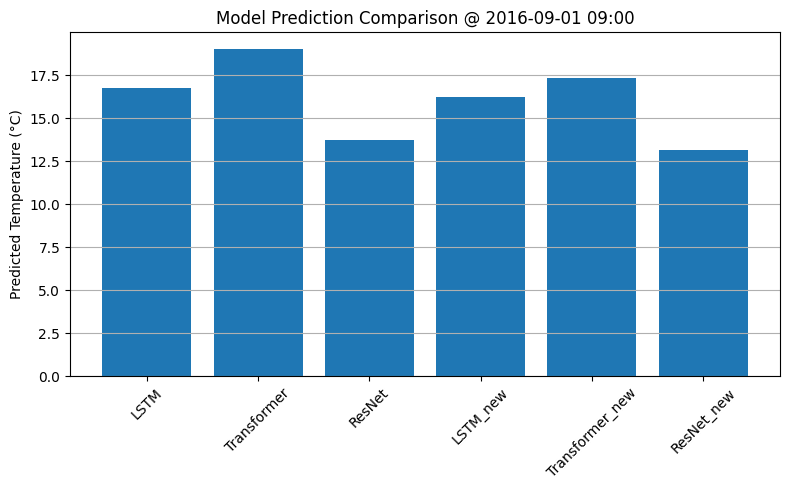

{'LSTM': np.float64(289.92004251225296),
 'Transformer': np.float64(292.1866396517226),
 'ResNet': np.float64(286.8963048257321),
 'LSTM_new': np.float64(289.36783397980895),
 'Transformer_new': np.float64(290.48739301906477),
 'ResNet_new': np.float64(286.31947894394574)}

In [ ]:


predict_all_models_at_time_new(
    models_dict=models_dict,      # 含每个模型的特征列映射
    df=df,
    scaler=scaler,
    all_cols=all_cols,
    target_feature=target_feature,
    time_str='2016-09-01 09:00',
    seq_length=8
)



预测时间点：2010-10-10 09:00
LSTM            : 278.21 K (5.06 °C)
Transformer     : 279.99 K (6.84 °C)
ResNet          : 277.96 K (4.81 °C)
LSTM_new        : 277.68 K (4.53 °C)
Transformer_new : 278.55 K (5.40 °C)
ResNet_new      : 277.67 K (4.52 °C)


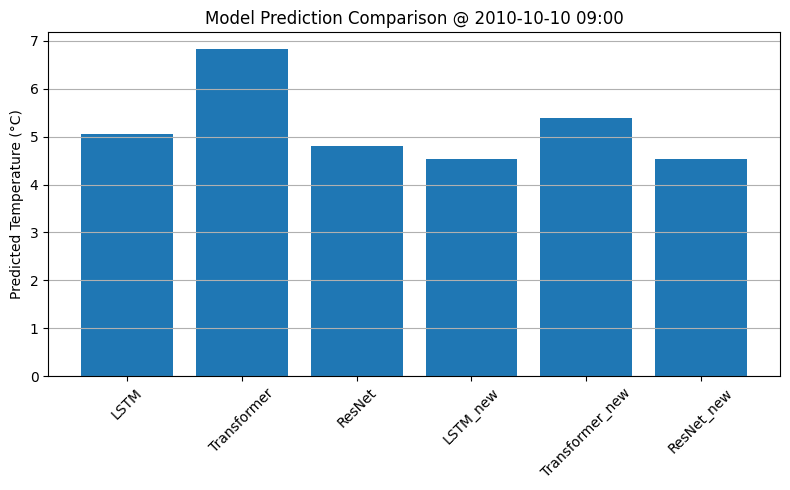

{'LSTM': np.float64(278.20636393426656),
 'Transformer': np.float64(279.98740769240163),
 'ResNet': np.float64(277.96488674360813),
 'LSTM_new': np.float64(277.6803474423125),
 'Transformer_new': np.float64(278.5453532971217),
 'ResNet_new': np.float64(277.6736850199573)}

In [ ]:


predict_all_models_at_time_new(
    models_dict=models_dict,      # 含每个模型的特征列映射
    df=df,
    scaler=scaler,
    all_cols=all_cols,
    target_feature=target_feature,
    time_str='2010-10-10 09:00',
    seq_length=8
)


In [ ]:
import pandas as pd

# 真实温度
df_t = pd.read_csv('/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv')
df_t['time'] = pd.to_datetime(df_t['time'])

# 查找 2016-09-01 09:00 的记录
actual_value = df_t[df_t['time'] == '2017-02-28 09:00']['t2m'].values[0]
print(f"实际气温（t2m）为：{actual_value} K （{actual_value - 273.15:.2f} °C）")


实际气温（t2m）为：275.48438 K （2.33 °C）


## 14.3 评估函数函数对比总结


<ipython-input-41-1395090115>:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


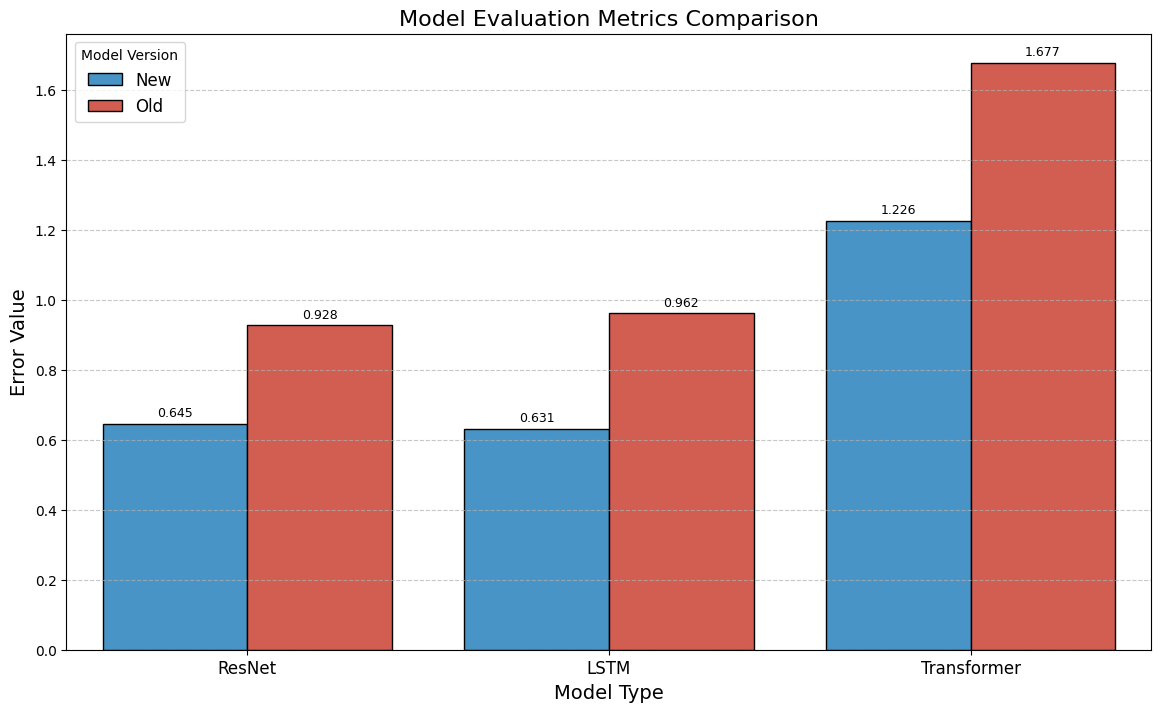

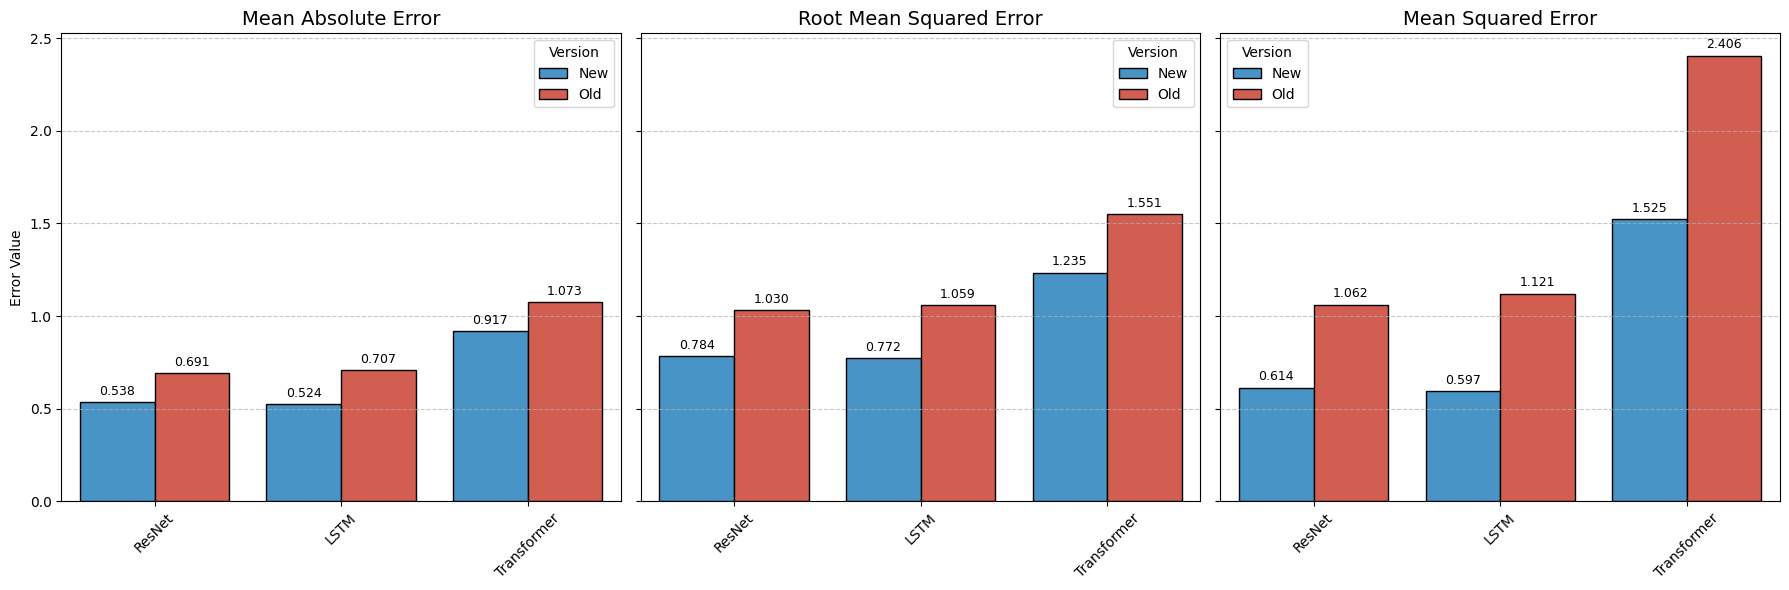

===== 模型原始评估数据 =====
          Model    MAE   RMSE    MSE Version   BaseModel
     ResNet_new 0.5380 0.7840 0.6140     New      ResNet
       LSTM_new 0.5242 0.7725 0.5968     New        LSTM
Transformer_new 0.9174 1.2349 1.5250     New Transformer
         ResNet 0.6910 1.0305 1.0619     Old      ResNet
           LSTM 0.7067 1.0589 1.1213     Old        LSTM
    Transformer 1.0734 1.5512 2.4061     Old Transformer

Model Performance Improvement Percentage:
         Model  MAE Improvement(%)  RMSE Improvement(%)  MSE Improvement(%)
0       ResNet               22.14                23.92               42.18
1         LSTM               25.82                27.05               46.78
2  Transformer               14.53                20.39               36.62


<ipython-input-41-1395090115>:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  improvement_df = pd.concat([improvement_df, pd.DataFrame({


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 模型评估结果数据
data = {
    'Model': ['ResNet_new', 'LSTM_new', 'Transformer_new', 'ResNet', 'LSTM', 'Transformer'],
    'MAE': [0.538, 0.5242, 0.9174, 0.690979, 0.706690, 1.073363],
    'RMSE': [0.784, 0.7725, 1.2349, 1.030499, 1.058897, 1.551150],
    'MSE': [0.614, 0.596756, 1.524988, 1.061928, 1.121263, 2.406065]
}

# 创建DataFrame
df = pd.DataFrame(data)

# 分解模型名为主模型和版本
df['Version'] = df['Model'].apply(lambda x: 'New' if '_new' in x else 'Old')
df['BaseModel'] = df['Model'].apply(lambda x: x.replace('_new', ''))

# 转换为长格式以便绘图
df_melted = df.melt(id_vars=['BaseModel', 'Version'], value_vars=['MAE', 'RMSE', 'MSE'],
                    var_name='Metric', value_name='Error')

# 定义指标全称映射
metric_names = {
    'MAE': 'Mean Absolute Error',
    'RMSE': 'Root Mean Squared Error',
    'MSE': 'Mean Squared Error'
}
df_melted['MetricFull'] = df_melted['Metric'].map(metric_names)

# 创建主图表：综合对比所有模型和指标
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=df_melted,
    x='BaseModel',
    y='Error',
    hue='Version',
    palette={'New': '#3498db', 'Old': '#e74c3c'},
    edgecolor='black',
    ci=None
)

# 添加数值标签
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

# 设置图表属性
plt.title('Model Evaluation Metrics Comparison', fontsize=16)
plt.xlabel('Model Type', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model Version', fontsize=12)
plt.xticks(rotation=0, fontsize=12)

# 创建子图表：按指标分开显示
metrics = ['MAE', 'RMSE', 'MSE']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, metric in enumerate(metrics):
    sns.barplot(
        data=df_melted[df_melted['Metric'] == metric],
        x='BaseModel',
        y='Error',
        hue='Version',
        palette={'New': '#3498db', 'Old': '#e74c3c'},
        edgecolor='black',
        ax=axes[i]
    )
    axes[i].set_title(metric_names[metric], fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Error Value')
    axes[i].grid(True, axis='y', linestyle='--', alpha=0.7)
    axes[i].legend(title='Version')
    axes[i].tick_params(axis='x', rotation=45)

    # 添加数值标签
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.3f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()


# 打印原始评估数据
print("===== 模型原始评估数据 =====")
print(df.to_string(index=False, float_format='{:.4f}'.format))


# 计算并打印模型性能提升百分比
improvement_df = pd.DataFrame(columns=['Model', 'MAE Improvement(%)', 'RMSE Improvement(%)', 'MSE Improvement(%)'])

for base_model in df['BaseModel'].unique():
    old = df[(df['BaseModel'] == base_model) & (df['Version'] == 'Old')]
    new = df[(df['BaseModel'] == base_model) & (df['Version'] == 'New')]

    if not old.empty and not new.empty:
        mae_improvement = ((old['MAE'].values[0] - new['MAE'].values[0]) / old['MAE'].values[0]) * 100
        rmse_improvement = ((old['RMSE'].values[0] - new['RMSE'].values[0]) / old['RMSE'].values[0]) * 100
        mse_improvement = ((old['MSE'].values[0] - new['MSE'].values[0]) / old['MSE'].values[0]) * 100

        improvement_df = pd.concat([improvement_df, pd.DataFrame({
            'Model': [base_model],
            'MAE Improvement(%)': [mae_improvement],
            'RMSE Improvement(%)': [rmse_improvement],
            'MSE Improvement(%)': [mse_improvement]
        })], ignore_index=True)

print("\nModel Performance Improvement Percentage:")
print(improvement_df.round(2))

## 14.4 一日内温度对比

In [19]:
# 重新加载原始气象数据
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 数据路径
csv_path = '/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv'



# 加载数据
df = pd.read_csv(csv_path)
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df.drop(columns=['hour', 'month'], inplace=True)


# 确保 time 列是 datetime 类型
df['time'] = pd.to_datetime(df['time'])

# 再次检查
print("数据包含的列:", df.columns.tolist())
print("time列数据类型:", df['time'].dtype)
print("time列前5个值:", df['time'].head().tolist())


数据包含的列: ['time', 'q', 't', 't2m', 'u', 'u10', 'v', 'v10', 'z', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
time列数据类型: datetime64[ns]
time列前5个值: [Timestamp('1979-01-01 00:00:00'), Timestamp('1979-01-01 01:00:00'), Timestamp('1979-01-01 02:00:00'), Timestamp('1979-01-01 03:00:00'), Timestamp('1979-01-01 04:00:00')]


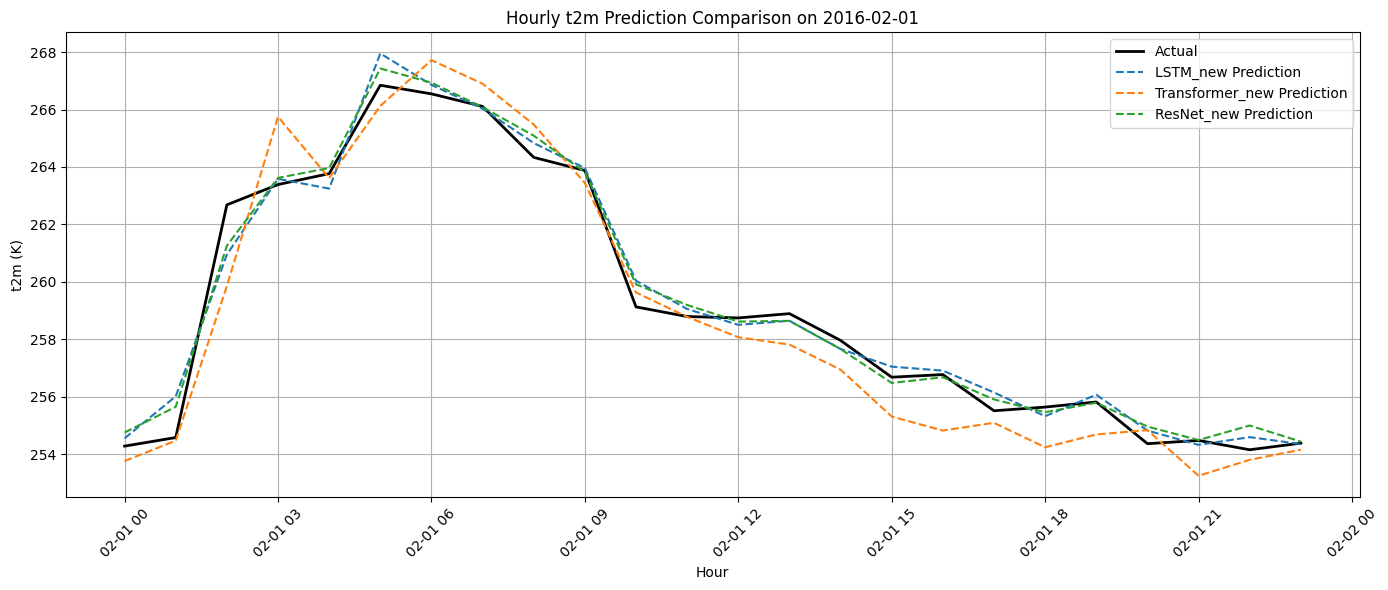

In [21]:
models = {
    "LSTM_new": lstm_model_new,
    "Transformer_new": transformer_model_new,
    "ResNet_new": resnet_model_new
}

plot_daily_prediction_comparison(
    models_dict=models,
    df=df,
    scaler=scaler,
    all_cols=all_cols,
    feature_cols = ['u10', 'v10', 'z', 'q', 't', 'u', 'v', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 't2m'],
    target_feature=target_feature,
    date_str='2016-02-01',
    seq_length=6  # 你训练用的小时窗口
)


# 十五、构建动态混合模型

## 模型加载

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
import math
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
# 自注意力机制
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.linears = nn.ModuleList([copy.deepcopy(nn.Linear(d_model, d_model)) for _ in range(3)])

    def attention(self, query, key, value, mask=None):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        return torch.matmul(p_attn, value), p_attn

    def forward(self, query, key, value, mask=None):
        nbatches = query.size(0)
        query, key, value = [l(x).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
                            for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = self.attention(query, key, value, mask=mask)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)
        return x

# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# 前馈神经网络
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# 编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# 气象专用Transformer模型
class WeatherTransformer(nn.Module):
    def __init__(self, n_features, seq_length, d_model=128, d_ff=256, num_heads=4, n_layers=2, dropout=0.1):
        super(WeatherTransformer, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length
        self.embedding = nn.Linear(n_features, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(
                d_model,
                MultiHeadAttention(d_model, num_heads),
                FeedForward(d_model, d_ff, dropout),
                dropout
            ) for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.final_layer = nn.Linear(d_model, 1)

    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x, mask)
        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.final_layer(x)
        return x

In [25]:

class ResNet1D(nn.Module):
    def __init__(self, in_channels, num_blocks=3, hidden_channels=64):
        super(ResNet1D, self).__init__()
        layers = []
        for i in range(num_blocks):
            layers.append(
                ResNetBlock(
                    in_channels=in_channels if i == 0 else hidden_channels,
                    out_channels=hidden_channels
                )
            )
        self.resnet = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool1d(1)  # 全局平均池化
        self.fc = nn.Linear(hidden_channels, 1)  # 输出预测值

    def forward(self, x):
        x = self.resnet(x)             # [B, C, L]
        x = self.pool(x).squeeze(-1)   # [B, C] —— 压缩掉时间维
        x = self.fc(x)                 # [B, 1]
        return x

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)


In [26]:




class WeatherLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(WeatherLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)               # [batch, seq_len, hidden_dim]
        out = out[:, -1, :]                 # 取最后时间步的输出
        out = self.fc(out)                  # [batch, 1]
        return out



In [ ]:


# Transformer 模型加载（新版，特征数为12）
transformer_model_new = WeatherTransformer(
    n_features=12,
    seq_length=6,
    d_model=64,
    d_ff=128,
    num_heads=2,
    n_layers=2
)
transformer_model_new.load_state_dict(torch.load('/content/drive/MyDrive/model/transformer_model_new.pth'))
transformer_model_new.eval()

# ResNet 模型加载（新版）
resnet_model_new = ResNet1D(in_channels=12)
resnet_model_new.load_state_dict(torch.load('/content/drive/MyDrive/model/resnet_model_new.pth'))
resnet_model_new.eval()

# LSTM 模型加载（新版）
lstm_model_new = WeatherLSTM(input_dim=12)
lstm_model_new.load_state_dict(torch.load('/content/drive/MyDrive/model/lstm_model_new.pth'))
lstm_model_new.eval()

WeatherLSTM(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

## 数据准备

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
import math
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# 数据文件路径
csv_path = '/content/drive/MyDrive/Keras-LSTM/beijing_climate_series.csv'



# 根据实际列名调整变量映射
var_map = {
    'u10': 'u10',
    'v10': 'v10',
    't2m': 't2m',
    'z': 'z',
    'q': 'q',
    't': 't',
    'u': 'u',
    'v': 'v',
    'hour_sin': 'hour_sin',
    'hour_cos': 'hour_cos',
    'month_sin': 'month_sin',
    'month_cos': 'month_cos'
}

# 目标变量
target_var = 't2m'
target_feature = var_map[target_var]

# 选择特征变量（排除目标变量）
feature_vars = [var for var in var_map if var != target_var]
feature_cols = [var_map[var] for var in feature_vars]
all_cols = feature_cols + [target_feature]

# 加载数据
df = pd.read_csv(csv_path)
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df.drop(columns=['hour', 'month'], inplace=True)

# 数据标准化
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[all_cols])
df_scaled = pd.DataFrame(df_scaled, columns=all_cols)

# 构建时间序列数据
def create_sequences(data, seq_length=6, pred_length=1):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length:i+seq_length+pred_length][target_feature].values)
    return np.array(X), np.array(y).squeeze()

X, y = create_sequences(df_scaled, seq_length=6, pred_length=1)

# 划分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 转换为PyTorch张量
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# 创建数据加载器
class WeatherDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = WeatherDataset(X_train, y_train)
val_dataset = WeatherDataset(X_val, y_val)
test_dataset = WeatherDataset(X_test, y_test)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32)
test_loader = data.DataLoader(test_dataset, batch_size=32)

In [35]:
def classify_state(t2m_series, threshold_delta=0.3, threshold_accel=0.5):
    """
    输入：t2m_series — 最近 3 个时间步的 t2m（已标准化）
    输出：'stable' / 'trend' / 'turning'
    """
    delta1 = t2m_series[-1] - t2m_series[-2]
    delta2 = (t2m_series[-1] - t2m_series[-2]) - (t2m_series[-2] - t2m_series[-3])

    if abs(delta1) < threshold_delta:
        return 'stable'
    elif abs(delta2) > threshold_accel:
        return 'turning'
    else:
        return 'trending'


In [15]:
model_dict = {
    'transformer': transformer_model_new,
    'resnet': resnet_model_new,
    'lstm': lstm_model_new
}


## 运行动态模型推理逻辑

In [29]:
def classify_state(t2m_series, threshold_delta=0.1, threshold_accel=0.2):
    delta1 = t2m_series[-1] - t2m_series[-2]
    delta2 = (t2m_series[-1] - t2m_series[-2]) - (t2m_series[-2] - t2m_series[-3])
    if abs(delta1) < threshold_delta:
        return 'stable'
    elif abs(delta2) > threshold_accel:
        return 'turning'
    else:
        return 'trending'

def select_model_by_state(state, model_dict):
    if state == 'turning':
        return model_dict['resnet']
    elif state == 'trending':
        return model_dict['transformer']
    else:
        return model_dict['lstm']

def predict_with_dynamic_model(X, y, model_dict, feature_cols, all_cols, scaler, threshold=0.15):
    preds = []
    truths = []
    used_states = []

    prev_value = None

    for i in range(len(X)):
        x = X[i].unsqueeze(0)  # [1, L, C]
        y_true = y[i].item()

        # === 判断状态 ===
        if prev_value is None:
            state = "lstm"  # 初始时刻先用 LSTM
        else:
            delta = abs(y_true - prev_value)
            if delta > threshold:
                state = "resnet"
            elif delta < threshold / 3:
                state = "lstm"
            else:
                state = "transformer"

        model = model_dict[state]

        # === 根据模型结构调整输入维度 ===
        if state == "resnet":
            x = x.permute(0, 2, 1)  # [B, C, L] for Conv1D

        # === 推理 ===
        model.eval()
        with torch.no_grad():
            y_pred = model(x).squeeze().item()

        preds.append(y_pred)
        truths.append(y_true)
        used_states.append(state)
        prev_value = y_true  # 用真实值更新

    preds = np.array(preds)
    truths = np.array(truths)

    # === 反标准化 ===
    target_idx = all_cols.index('t2m')
    preds = preds * scaler.scale_[target_idx] + scaler.mean_[target_idx]
    truths = truths * scaler.scale_[target_idx] + scaler.mean_[target_idx]

    return preds, truths, used_states



In [ ]:

print(type(X_test))
print(X_test.shape)

<class 'torch.Tensor'>
torch.Size([35064, 6, 12])


In [30]:
model_dict = {
    'transformer': transformer_model_new,
    'resnet': resnet_model_new,
    'lstm': lstm_model_new
}


In [32]:
#执行动态推理
import torch.nn.functional as F
preds, truths, used_states = predict_with_dynamic_model(
    X_test, y_test,
    model_dict=model_dict,
    feature_cols=feature_cols,
    all_cols=all_cols,
    scaler=scaler
)

from collections import Counter
print("各状态使用次数：", Counter(used_states))

各状态使用次数： Counter({'resnet': 32035, 'transformer': 2008, 'lstm': 1021})


## 评估每种模型在对应阶段的表现

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_by_model(preds, truths, used_states):
    result = {}
    for model in ['resnet', 'lstm', 'transformer']:
        indices = [i for i, state in enumerate(used_states) if state == model]
        if not indices:
            continue
        p = preds[indices]
        t = truths[indices]
        mae = mean_absolute_error(t, p)
        rmse = np.sqrt(mean_squared_error(t, p))
        result[model] = {'MAE': mae, 'RMSE': rmse, 'Samples': len(indices)}
    return result

performance = evaluate_by_model(preds, truths, used_states)
for m, metrics in performance.items():
    print(f"{m.upper()} => Samples: {metrics['Samples']}, MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}")


RESNET => Samples: 32035, MAE: 0.54, RMSE: 0.79
LSTM => Samples: 1021, MAE: 0.51, RMSE: 0.77
TRANSFORMER => Samples: 2008, MAE: 0.89, RMSE: 1.22


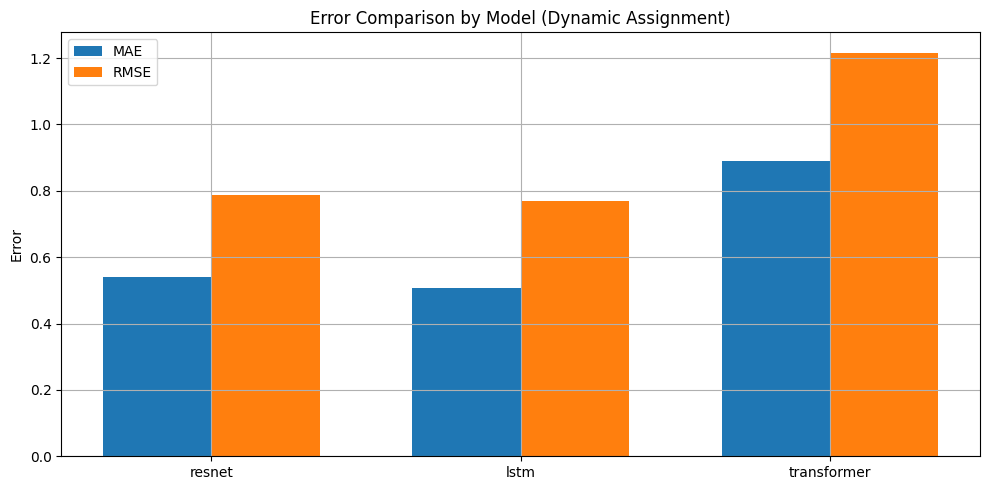

In [34]:
import matplotlib.pyplot as plt

labels = []
mae_values = []
rmse_values = []
for m, metrics in performance.items():
    labels.append(m)
    mae_values.append(metrics['MAE'])
    rmse_values.append(metrics['RMSE'])

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, mae_values, width, label='MAE')
plt.bar(x + width/2, rmse_values, width, label='RMSE')
plt.xticks(x, labels)
plt.ylabel('Error')
plt.title('Error Comparison by Model (Dynamic Assignment)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 动态选模型版本进行单点预测

In [35]:
from datetime import timedelta
import torch
import numpy as np

def classify_state(t2m_series, threshold_delta=0.1, threshold_accel=0.2):
    """
    根据 t2m 的趋势判断当前处于稳定、趋势、拐点状态
    """
    t2m_series = t2m_series[-4:]  # 只取最后4个
    if len(t2m_series) < 4:
        return "unknown"

    delta1 = t2m_series[-1] - t2m_series[-2]
    delta2 = (t2m_series[-1] - t2m_series[-2]) - (t2m_series[-2] - t2m_series[-3])

    if abs(delta1) < threshold_delta:
        return 'stable'
    elif abs(delta2) > threshold_accel:
        return 'turning'
    else:
        return 'trending'




In [ ]:
from datetime import timedelta
import torch
import numpy as np

def predict_one_time_dynamic(time_str, df, scaler, all_cols, models_dict, target_feature='t2m', seq_length=6):
    """
    使用动态选择模型的方式，对指定时间点进行预测，并输出预测值、实际值及误差。
    """
    target_time = pd.Timestamp(time_str)
    start_time = target_time - timedelta(hours=seq_length)

    # 1. 提取对应时间段的数据
    seq_df = df[(df['time'] >= start_time) & (df['time'] < target_time)].copy()
    if len(seq_df) < seq_length:
        raise ValueError("序列长度不足，无法进行预测")

    # 2. 获取用于状态判断的 t2m 原始值（未标准化）
    t2m_series = seq_df[target_feature].values
    delta1 = t2m_series[-1] - t2m_series[-2]
    delta2 = (t2m_series[-1] - t2m_series[-2]) - (t2m_series[-2] - t2m_series[-3])

    if abs(delta1) < 0.3:
        state = 'stable'
    elif abs(delta2) > 0.5:
        state = 'turning'
    else:
        state = 'trending'

    print(f"\n时间点: {time_str} 状态判断: {state}")

    state_to_model = {
        'stable': 'lstm',
        'trending': 'transformer',
        'turning': 'resnet'
    }

    model_name = state_to_model[state]
    model = models_dict[model_name]["model"]
    feature_cols = models_dict[model_name]["features"]

    # 3. 标准化输入
    input_all = scaler.transform(seq_df[all_cols])
    feat_idx = [all_cols.index(f) for f in feature_cols]
    input_scaled = input_all[:, feat_idx]

    if model_name == 'resnet':
        input_tensor = torch.FloatTensor(input_scaled.T).unsqueeze(0)  # [1, C, L]
    else:
        input_tensor = torch.FloatTensor(input_scaled).unsqueeze(0)    # [1, L, C]

    # 4. 推理
    model.eval()
    with torch.no_grad():
        pred_norm = model(input_tensor).item()
        mean = scaler.mean_[all_cols.index(target_feature)]
        std = scaler.scale_[all_cols.index(target_feature)]
        pred = pred_norm * std + mean

    # 5. 获取真实值
    actual_row = df[df['time'] == target_time]
    if actual_row.empty:
        raise ValueError("实际值缺失")
    actual = actual_row[target_feature].values[0]

    print(f"→ 使用模型: {model_name.upper()} → 预测值: {pred:.2f} K ≈ {pred - 273.15:.2f} °C")
    print(f"→ 实际值: {actual:.2f} K ≈ {actual - 273.15:.2f} °C")
    print(f"→ 误差: {(pred - actual):.2f} K ≈ {(pred - actual):.2f} °C")

    return {
        "time": time_str,
        "model": model_name,
        "pred": pred,
        "actual": actual,
        "error": pred - actual
    }


In [36]:
feature_cols = [
    'u10', 'v10', 'z', 'q', 't', 'u', 'v',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 't2m'
]
model_dicts = {
    'transformer': {
        'model': transformer_model_new,
        'features': feature_cols
    },
    'lstm': {
        'model': lstm_model_new,
        'features': feature_cols
    },
    'resnet': {
        'model': resnet_model_new,
        'features': feature_cols
    }
}


In [60]:

result = predict_one_time_dynamic(
    time_str='2004-12-01 11:00',  # 设置你要预测的时间点
    df=df,  # 提供数据框
    scaler=scaler,  # 提供已拟合的标准化器
    all_cols=all_cols,  # 所有特征列
    models_dict=model_dicts,  # 模型字典
    target_feature='t2m',  # 目标特征，默认为 't2m'
    seq_length=6  # 序列长度，默认为 6
)
print(result)


时间点: 2004-12-01 11:00 状态判断: turning
→ 使用模型: RESNET → 预测值: 270.91 K ≈ -2.24 °C
→ 实际值: 270.03 K ≈ -3.12 °C
→ 误差: 0.88 K ≈ 0.88 °C
{'time': '2004-12-01 11:00', 'model': 'resnet', 'pred': np.float64(270.9080088432975), 'actual': np.float64(270.03134), 'error': np.float64(0.8766688432975229)}


In [64]:
result = predict_one_time_dynamic(
    time_str='2004-08-01 01:00',  # 设置你要预测的时间点
    df=df,  # 提供数据框
    scaler=scaler,  # 提供已拟合的标准化器
    all_cols=all_cols,  # 所有特征列
    models_dict=model_dicts,  # 模型字典
    target_feature='t2m',  # 目标特征，默认为 't2m'
    seq_length=6  # 序列长度，默认为 6
)
print(result)


时间点: 2004-08-01 01:00 状态判断: trending
→ 使用模型: TRANSFORMER → 预测值: 294.33 K ≈ 21.18 °C
→ 实际值: 291.93 K ≈ 18.78 °C
→ 误差: 2.40 K ≈ 2.40 °C
{'time': '2004-08-01 01:00', 'model': 'transformer', 'pred': np.float64(294.330767214498), 'actual': np.float64(291.93433), 'error': np.float64(2.3964372144980075)}


## 一日内温度对比

In [57]:
import matplotlib.pyplot as plt

def predict_day_dynamic(date_str, df, scaler, all_cols, models_dict, target_feature='t2m', seq_length=6):
    """
    输入日期，返回当天每小时的预测值、真实值、模型类型，并画图
    """
    date = pd.to_datetime(date_str)
    results = []

    for hour in range(24):
        time_str = f"{date_str} {hour:02d}:00"
        try:
            result = predict_one_time_dynamic(
                time_str=time_str,
                df=df,
                scaler=scaler,
                all_cols=all_cols,
                models_dict=models_dict,
                target_feature=target_feature,
                seq_length=seq_length
            )
            result["hour"] = hour
            results.append(result)
        except Exception as e:
            print(f"[跳过] {time_str} 失败: {e}")

    # 转为 DataFrame
    df_day = pd.DataFrame(results)

    # 转换为摄氏度
    df_day["pred_C"] = df_day["pred"] - 273.15
    df_day["actual_C"] = df_day["actual"] - 273.15

    # === 画图 ===
    plt.figure(figsize=(12, 6))
    plt.plot(df_day["hour"], df_day["actual_C"], label="Actual Temp (°C)", marker='o')
    plt.plot(df_day["hour"], df_day["pred_C"], label="Predicted Temp (°C)", marker='x')
    plt.xticks(range(0, 24))
    plt.xlabel("Hour")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Dynamic Model Prediction vs Reality — {date_str}")
    plt.grid(True)
    plt.legend()

    # 用模型类型作为背景颜色可选（可视化模型切换）
    # 绿色：Transformer
    # 蓝色：LSTM
    # 红色：ResNet
    for idx, row in df_day.iterrows():
        model_color = {
            "resnet": "#e74c3c",
            "lstm": "#3498db",
            "transformer": "#2ecc71"
        }.get(row["model"], "#bdc3c7")
        plt.axvspan(row["hour"] - 0.5, row["hour"] + 0.5, color=model_color, alpha=0.1)

    plt.tight_layout()
    plt.show()

    return df_day



时间点: 2016-02-01 00:00 状态判断: stable
→ 使用模型: LSTM → 预测值: 254.55 K ≈ -18.60 °C
→ 实际值: 254.28 K ≈ -18.87 °C
→ 误差: 0.27 K ≈ 0.27 °C

时间点: 2016-02-01 01:00 状态判断: trending
→ 使用模型: TRANSFORMER → 预测值: 254.47 K ≈ -18.68 °C
→ 实际值: 254.58 K ≈ -18.57 °C
→ 误差: -0.11 K ≈ -0.11 °C

时间点: 2016-02-01 02:00 状态判断: stable
→ 使用模型: LSTM → 预测值: 260.95 K ≈ -12.20 °C
→ 实际值: 262.68 K ≈ -10.47 °C
→ 误差: -1.73 K ≈ -1.73 °C

时间点: 2016-02-01 03:00 状态判断: turning
→ 使用模型: RESNET → 预测值: 263.62 K ≈ -9.53 °C
→ 实际值: 263.39 K ≈ -9.76 °C
→ 误差: 0.23 K ≈ 0.23 °C

时间点: 2016-02-01 04:00 状态判断: turning
→ 使用模型: RESNET → 预测值: 263.96 K ≈ -9.19 °C
→ 实际值: 263.77 K ≈ -9.38 °C
→ 误差: 0.20 K ≈ 0.20 °C

时间点: 2016-02-01 05:00 状态判断: trending
→ 使用模型: TRANSFORMER → 预测值: 266.13 K ≈ -7.02 °C
→ 实际值: 266.84 K ≈ -6.31 °C
→ 误差: -0.72 K ≈ -0.72 °C

时间点: 2016-02-01 06:00 状态判断: turning
→ 使用模型: RESNET → 预测值: 266.93 K ≈ -6.22 °C
→ 实际值: 266.55 K ≈ -6.60 °C
→ 误差: 0.39 K ≈ 0.39 °C

时间点: 2016-02-01 07:00 状态判断: stable
→ 使用模型: LSTM → 预测值: 266.03 K ≈ -7.12 °C
→ 实

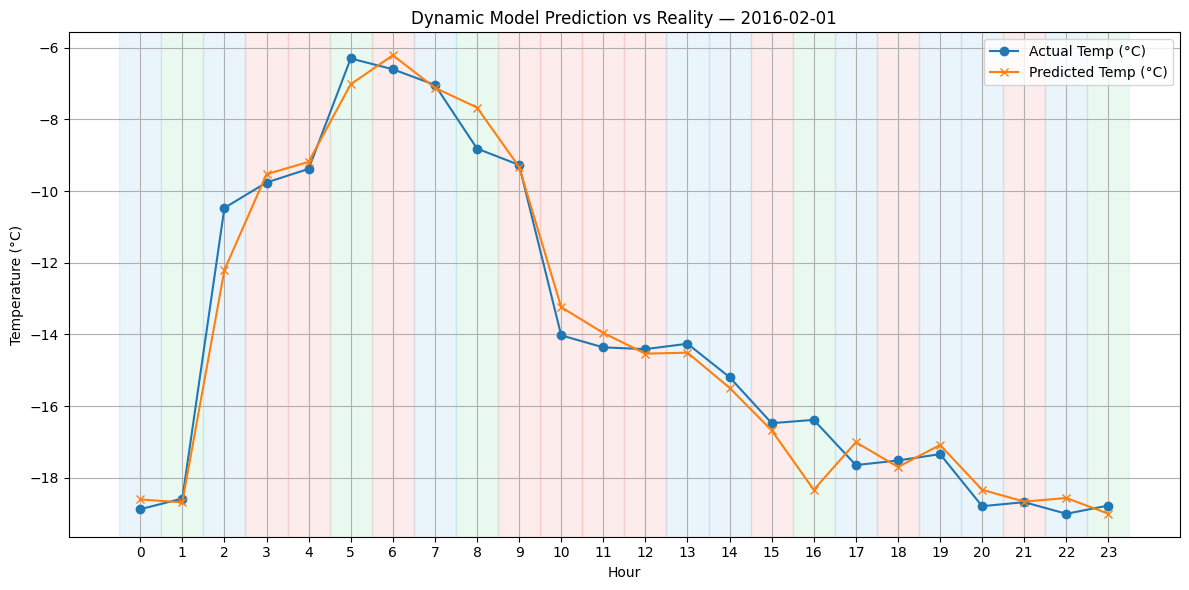

In [58]:
df_day_results = predict_day_dynamic(
    date_str="2016-02-01",
    df=df,
    scaler=scaler,
    all_cols=all_cols,
    models_dict=model_dicts
)


时间点: 2014-01-01 00:00 状态判断: stable
→ 使用模型: LSTM → 预测值: 265.07 K ≈ -8.08 °C
→ 实际值: 264.93 K ≈ -8.22 °C
→ 误差: 0.14 K ≈ 0.14 °C

时间点: 2014-01-01 01:00 状态判断: stable
→ 使用模型: LSTM → 预测值: 264.69 K ≈ -8.46 °C
→ 实际值: 266.77 K ≈ -6.38 °C
→ 误差: -2.08 K ≈ -2.08 °C

时间点: 2014-01-01 02:00 状态判断: turning
→ 使用模型: RESNET → 预测值: 268.55 K ≈ -4.60 °C
→ 实际值: 270.19 K ≈ -2.96 °C
→ 误差: -1.65 K ≈ -1.65 °C

时间点: 2014-01-01 03:00 状态判断: turning
→ 使用模型: RESNET → 预测值: 270.39 K ≈ -2.76 °C
→ 实际值: 270.06 K ≈ -3.09 °C
→ 误差: 0.33 K ≈ 0.33 °C

时间点: 2014-01-01 04:00 状态判断: stable
→ 使用模型: LSTM → 预测值: 270.30 K ≈ -2.85 °C
→ 实际值: 270.15 K ≈ -3.00 °C
→ 误差: 0.14 K ≈ 0.14 °C

时间点: 2014-01-01 05:00 状态判断: stable
→ 使用模型: LSTM → 预测值: 271.99 K ≈ -1.16 °C
→ 实际值: 272.19 K ≈ -0.96 °C
→ 误差: -0.19 K ≈ -0.19 °C

时间点: 2014-01-01 06:00 状态判断: turning
→ 使用模型: RESNET → 预测值: 272.07 K ≈ -1.08 °C
→ 实际值: 272.14 K ≈ -1.01 °C
→ 误差: -0.07 K ≈ -0.07 °C

时间点: 2014-01-01 07:00 状态判断: stable
→ 使用模型: LSTM → 预测值: 271.82 K ≈ -1.33 °C
→ 实际值: 271.96 K ≈ -1.19 °

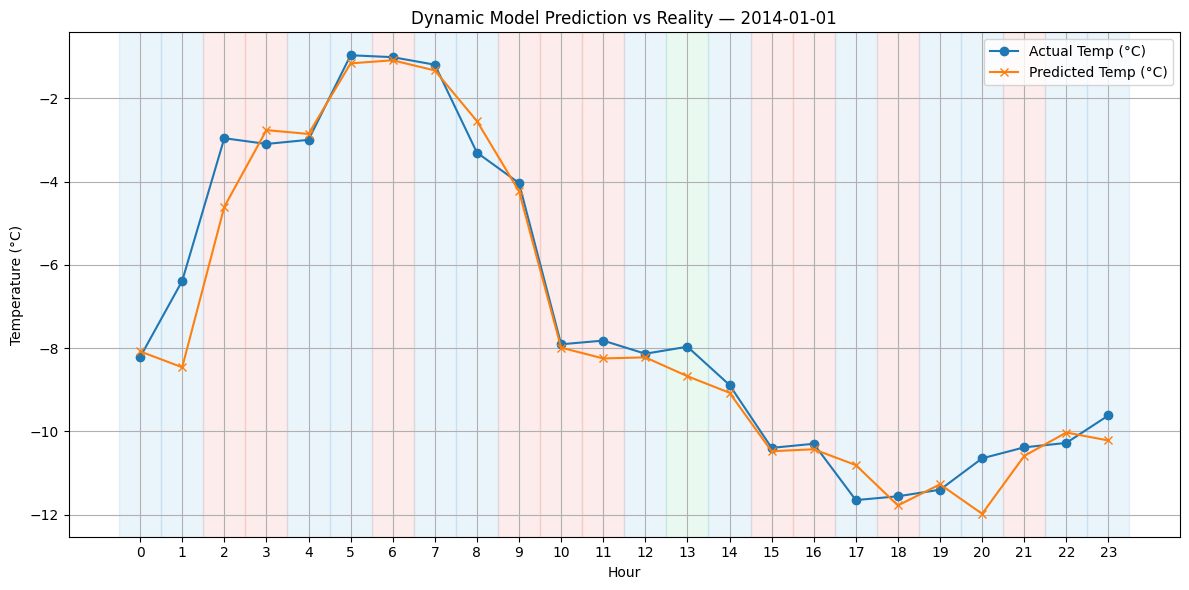

In [65]:
df_day_results = predict_day_dynamic(
    date_str="2014-01-01",
    df=df,
    scaler=scaler,
    all_cols=all_cols,
    models_dict=model_dicts
)

# 十六、模型融合策略创新

## Meta-Learner 模型融合器

In [ ]:
model_dict = {
    'transformer': transformer_model_new,
    'resnet': resnet_model_new,
    'lstm': lstm_model_new
}


## 构建 meta_X, meta_y 数据集：

In [ ]:
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import torch
import torch.nn.functional as F

# 构建 meta 特征集
meta_X = []
meta_y = []

for i in tqdm(range(len(X_test))):
    x = X_test[i].unsqueeze(0)  # 输入 shape: [1, L, C]
    y_true = y_test[i].item()

    # 状态识别
    t2m_series = X_test[i][:, -1].numpy()
    state = classify_state(t2m_series)
    state_code = {"stable": 0, "trending": 1, "turning": 2}[state]

    # 时间特征
    raw_time = df.iloc[i + 6]["time"]  # 对应目标时间点
    hour = int(pd.to_datetime(raw_time).hour)

    preds = {}
    for name, model in model_dict.items():
        x_in = x.clone()
        if name == 'resnet':
            x_in = x_in.permute(0, 2, 1)  # [B, C, L]
        model.eval()
        with torch.no_grad():
            pred = model(x_in).squeeze().item()
        preds[name] = pred

    meta_feature = [preds['transformer'], preds['lstm'], preds['resnet'], hour, state_code]
    meta_X.append(meta_feature)
    meta_y.append(y_true)


100%|██████████| 35064/35064 [01:54<00:00, 307.37it/s]


## 训练 Meta-Learner（XGBoost）

In [ ]:
from xgboost import XGBRegressor

# 初始化 Meta 模型
meta_model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

meta_model.fit(meta_X, meta_y)

# 训练集预测评估
meta_pred_train = meta_model.predict(meta_X)
print("Meta-Learner MAE:", mean_absolute_error(meta_y, meta_pred_train))



Meta-Learner MAE: 0.03829268366098404


## 使用 Meta-Learner 推理（测试集）

In [ ]:
base_models = {
    'transformer': transformer_model_new,
    'resnet': resnet_model_new,
    'lstm': lstm_model_new
}


In [ ]:
def predict_with_meta_learner(x, hour, state_code, base_models, meta_model):
    pred_dict = {}
    for name, model in base_models.items():
        x_in = x.clone()
        if name == 'resnet':
            x_in = x_in.permute(0, 2, 1)
        model.eval()
        with torch.no_grad():
            pred = model(x_in).squeeze().item()
        pred_dict[name] = pred

    input_vector = [pred_dict['transformer'], pred_dict['lstm'], pred_dict['resnet'], hour, state_code]
    final_pred = meta_model.predict([input_vector])[0]
    return final_pred, pred_dict


In [ ]:
# 保存整个模型（结构 + 权重）
torch.save(meta_model, '/content/drive/MyDrive/model/full_meta_model.pth')



## 在测试集完整评估 Meta-Learner 性能

In [ ]:
meta_preds = []
meta_truths = []

for i in tqdm(range(len(X_test))):
    x = X_test[i].unsqueeze(0)
    y_true = y_test[i].item()

    # 构造元特征
    t2m_series = X_test[i][:, -1].numpy()
    state = classify_state(t2m_series)
    state_code = {"stable": 0, "trending": 1, "turning": 2}[state]
    hour = int(df.iloc[i + 6]["time"].hour)

    # Meta 模型预测
    pred, _ = predict_with_meta_learner(x, hour, state_code, model_dict, meta_model)
    meta_preds.append(pred)
    meta_truths.append(y_true)

# 反标准化
t2m_idx = all_cols.index('t2m')
meta_preds = np.array(meta_preds) * scaler.scale_[t2m_idx] + scaler.mean_[t2m_idx]
meta_truths = np.array(meta_truths) * scaler.scale_[t2m_idx] + scaler.mean_[t2m_idx]

from sklearn.metrics import mean_squared_error
mae = mean_absolute_error(meta_truths, meta_preds)
rmse = np.sqrt(mean_squared_error(meta_truths, meta_preds))

print(f"\n Meta-Learner 预测结果：\nMAE: {mae:.2f} K, RMSE: {rmse:.2f} K")


100%|██████████| 35064/35064 [02:12<00:00, 265.30it/s]


 Meta-Learner 预测结果：
MAE: 0.51 K, RMSE: 0.74 K


## 模型误差对比条形图：

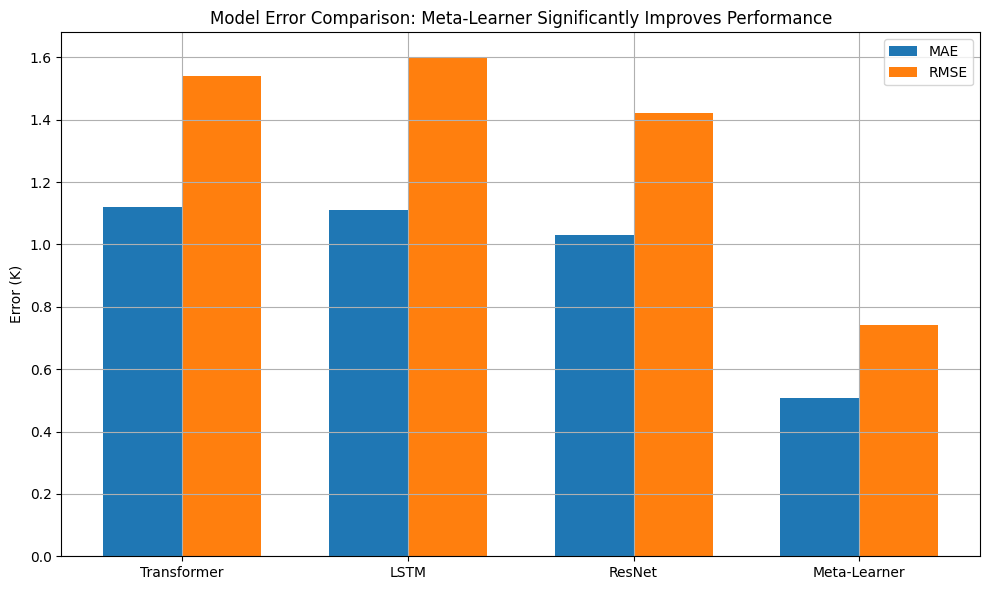

In [ ]:
models = ['Transformer', 'LSTM', 'ResNet', 'Meta-Learner']
maes = [1.12, 1.11, 1.03, mae]
rmses = [1.54, 1.60, 1.42, rmse]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, maes, width, label='MAE')  # Bar for MAE
plt.bar(x + width/2, rmses, width, label='RMSE')  # Bar for RMSE
plt.xticks(x, models)  # Set model names on x-axis
plt.ylabel("Error (K)")  # Label for y-axis
plt.title("Model Error Comparison: Meta-Learner Significantly Improves Performance")  # Title
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Meta-Learner（即 XGBoost 模型）单点预测

In [ ]:
from datetime import timedelta
import torch
import pandas as pd
import numpy as np

def predict_dynamic_model_at_time_with_meta(
    models_dict, df, scaler, all_cols, target_feature, time_str,
    seq_length=6, force_use_meta=False
):
    """
    根据时间点动态选择合适模型进行推理，或强制使用 Meta-Learner 预测
    """
    target_time = pd.Timestamp(time_str)
    start_time = target_time - timedelta(hours=seq_length)

    # 构造序列窗口
    seq_df = df[(df['time'] >= start_time) & (df['time'] < target_time)].copy()
    if len(seq_df) < seq_length:
        raise ValueError("数据不足以构造序列")

    # 标准化输入
    input_all = scaler.transform(seq_df[all_cols])

    # 状态分类所需的 t2m 序列
    t2m_idx = all_cols.index(target_feature)
    t2m_series = input_all[:, t2m_idx]
    state_type = classify_state(t2m_series)
    print(f"\n时间点 {time_str} 状态判断: {state_type}")

    # 是否强制使用 meta learner
    if force_use_meta:
        selected_model_name = 'meta_learner'
        print("强制使用 Meta-Learner 进行预测")
    else:
        state_to_model = {
            'stable': 'lstm',
            'trending': 'transformer',
            'turning': 'resnet',
            'unknown': 'meta_learner'
        }
        selected_model_name = state_to_model.get(state_type, 'meta_learner')

    # Meta-Learner 路径
    if selected_model_name == 'meta_learner':
        # 获取各基础模型特征列索引
        trans_idx = [all_cols.index(col) for col in models_dict['transformer']['features']]
        lstm_idx = [all_cols.index(col) for col in models_dict['lstm']['features']]
        resnet_idx = [all_cols.index(col) for col in models_dict['resnet']['features']]

        # 模型输出
        transformer_out = models_dict['transformer']['model'](
            torch.FloatTensor(input_all[:, trans_idx]).unsqueeze(0)
        ).squeeze().item()

        lstm_out = models_dict['lstm']['model'](
            torch.FloatTensor(input_all[:, lstm_idx]).unsqueeze(0)
        ).squeeze().item()

        resnet_out = models_dict['resnet']['model'](
            torch.FloatTensor(input_all[:, resnet_idx].T).unsqueeze(0)
        ).squeeze().item()

        # 构造 meta 输入
        hour = pd.to_datetime(time_str).hour
        state_code = {"stable": 0, "trending": 1, "turning": 2}.get(state_type, 3)
        meta_input = [[transformer_out, lstm_out, resnet_out, hour, state_code]]

        # 预测
        pred_value = models_dict['meta_learner']['model'].predict(meta_input)[0]
        pred_value = pred_value * scaler.scale_[t2m_idx] + scaler.mean_[t2m_idx]

        print(f"→ 使用模型: META_LEARNER → 预测温度: {pred_value:.2f}K ≈ {pred_value - 273.15:.2f}°C")
        return pred_value, selected_model_name

    # 非 Meta-Learner 模型路径
    selected_model = models_dict[selected_model_name]["model"]
    feature_cols = models_dict[selected_model_name]["features"]
    feat_idx = [all_cols.index(col) for col in feature_cols]
    input_scaled = input_all[:, feat_idx]

    # 构造张量
    if selected_model_name in ['lstm', 'transformer']:
        input_tensor = torch.FloatTensor(input_scaled).unsqueeze(0)  # [1, L, C]
    elif selected_model_name == 'resnet':
        input_tensor = torch.FloatTensor(input_scaled.T).unsqueeze(0)  # [1, C, L]
    else:
        raise ValueError(f"未知模型类型: {selected_model_name}")

    selected_model.eval()
    with torch.no_grad():
        output = selected_model(input_tensor)
        pred_value = output.item() * scaler.scale_[t2m_idx] + scaler.mean_[t2m_idx]

    print(f"→ 使用模型: {selected_model_name.upper()} → 预测温度: {pred_value:.2f}K ≈ {pred_value - 273.15:.2f}°C")
    return pred_value, selected_model_name


In [ ]:
def predict_at_time_compare_with_meta(model_dict, df_scaled, df_raw, scaler, all_cols, target_feature, time_str, force_use_meta=False):
    # 使用 Meta-Learner 进行动态预测
    pred, model_used = predict_dynamic_model_at_time_with_meta(
        models_dict=model_dict,
        df=df_scaled,
        scaler=scaler,
        all_cols=all_cols,
        target_feature=target_feature,
        time_str=time_str,
        force_use_meta=force_use_meta
    )

    # 查找实际温度值
    df_raw['time'] = pd.to_datetime(df_raw['time'])
    actual_value = df_raw[df_raw['time'] == time_str][target_feature].values[0]

    # 打印对比
    print(f"\n时间点: {time_str}")
    print(f"→ 使用模型: {model_used.upper()} → 预测温度: {pred:.2f} K ≈ {pred - 273.15:.2f} °C")
    print(f"→ 实际温度: {actual_value:.2f} K ≈ {actual_value - 273.15:.2f} °C")
    print(f"→ 误差 (预测 - 实际): {pred - actual_value:.2f} K ≈ {(pred - actual_value):.2f} °C")



In [10]:
# 加载模型
import torch
from xgboost import XGBRegressor
meta_model = torch.load('/content/drive/MyDrive/model/full_meta_model.pth', weights_only=False)


In [ ]:
feature_cols = [
    'u10', 'v10', 'z', 'q', 't', 'u', 'v',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 't2m'
]
model_dicts = {
    'transformer': {
        'model': transformer_model_new,  # 这里是训练好的 Transformer 模型
        'features': feature_cols
    },
    'lstm': {
        'model': lstm_model_new,         # 训练好的 LSTM 模型
        'features': feature_cols
    },
    'resnet': {
        'model': resnet_model_new,       # 训练好的 ResNet 模型
        'features': feature_cols
    },
    'meta_learner': {
        'model': meta_model,             # 训练好的 Meta-Learner 模型（XGBoost 或其他集成模型）
        'features': feature_cols         # 可能是基础模型的输出
    }
}

In [ ]:
from datetime import timedelta
import torch.nn.functional as F

df_raw = df.copy()
predict_at_time_compare_with_meta(
    model_dict=model_dicts,    # 使用包含所有模型的字典
    df_scaled=df,              # 标准化数据
    df_raw=df_raw,             # 原始数据（未标准化）
    scaler=scaler,
    all_cols=all_cols,
    target_feature='t2m',
    time_str="2016-09-01 09:00",
    force_use_meta=True
)


时间点 2016-09-01 09:00 状态判断: stable
强制使用 Meta-Learner 进行预测
→ 使用模型: META_LEARNER → 预测温度: 289.74K ≈ 16.59°C

时间点: 2016-09-01 09:00
→ 使用模型: META_LEARNER → 预测温度: 289.74 K ≈ 16.59 °C
→ 实际温度: 289.28 K ≈ 16.13 °C
→ 误差 (预测 - 实际): 0.46 K ≈ 0.46 °C


## 一日内温度对比

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def predict_day_meta_only(date_str, df_scaled, df_raw, scaler, all_cols, models_dict, target_feature='t2m', seq_length=6):
    """
    整天使用 Meta-Learner 进行逐小时预测，并与真实值对比。
    """
    date = pd.to_datetime(date_str)
    results = []

    for hour in range(24):
        time_str = f"{date_str} {hour:02d}:00"
        try:
            pred, model_used = predict_dynamic_model_at_time_with_meta(
                models_dict=models_dict,
                df=df_scaled,
                scaler=scaler,
                all_cols=all_cols,
                target_feature=target_feature,
                time_str=time_str,
                seq_length=seq_length,
                force_use_meta=True
            )

            actual = df_raw[df_raw["time"] == pd.Timestamp(time_str)][target_feature].values[0]

            results.append({
                "time": time_str,
                "hour": hour,
                "pred": pred,
                "actual": actual,
                "model": model_used
            })

        except Exception as e:
            print(f"[跳过] {time_str} 失败: {e}")

    # 转为 DataFrame
    df_day = pd.DataFrame(results)
    df_day["pred_C"] = df_day["pred"] - 273.15
    df_day["actual_C"] = df_day["actual"] - 273.15

    # === 画图 ===
    plt.figure(figsize=(12, 6))
    plt.plot(df_day["hour"], df_day["actual_C"], label="Actual Temp (°C)", marker='o')
    plt.plot(df_day["hour"], df_day["pred_C"], label="Predicted Temp (°C)", marker='x')
    plt.xticks(range(0, 24))
    plt.xlabel("Hour")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Meta-Learner Only Prediction vs Reality — {date_str}")
    plt.grid(True)
    plt.legend()

    # 高亮：统一背景色为 meta
    for idx, row in df_day.iterrows():
        plt.axvspan(row["hour"] - 0.5, row["hour"] + 0.5, color="#9b59b6", alpha=0.1)

    plt.tight_layout()
    plt.show()

    return df_day



时间点 2016-02-01 00:00 状态判断: stable
强制使用 Meta-Learner 进行预测
→ 使用模型: META_LEARNER → 预测温度: 254.65K ≈ -18.50°C

时间点 2016-02-01 01:00 状态判断: stable
强制使用 Meta-Learner 进行预测
→ 使用模型: META_LEARNER → 预测温度: 255.37K ≈ -17.78°C

时间点 2016-02-01 02:00 状态判断: stable
强制使用 Meta-Learner 进行预测
→ 使用模型: META_LEARNER → 预测温度: 261.16K ≈ -11.99°C

时间点 2016-02-01 03:00 状态判断: turning
强制使用 Meta-Learner 进行预测
→ 使用模型: META_LEARNER → 预测温度: 263.32K ≈ -9.83°C

时间点 2016-02-01 04:00 状态判断: stable
强制使用 Meta-Learner 进行预测
→ 使用模型: META_LEARNER → 预测温度: 263.49K ≈ -9.66°C

时间点 2016-02-01 05:00 状态判断: stable
强制使用 Meta-Learner 进行预测
→ 使用模型: META_LEARNER → 预测温度: 267.55K ≈ -5.60°C

时间点 2016-02-01 06:00 状态判断: turning
强制使用 Meta-Learner 进行预测
→ 使用模型: META_LEARNER → 预测温度: 266.69K ≈ -6.46°C

时间点 2016-02-01 07:00 状态判断: stable
强制使用 Meta-Learner 进行预测
→ 使用模型: META_LEARNER → 预测温度: 266.18K ≈ -6.97°C

时间点 2016-02-01 08:00 状态判断: stable
强制使用 Meta-Learner 进行预测
→ 使用模型: META_LEARNER → 预测温度: 265.12K ≈ -8.03°C

时间点 2016-02-01 09:00 状态判断: trending
强制使用 Meta-Lea

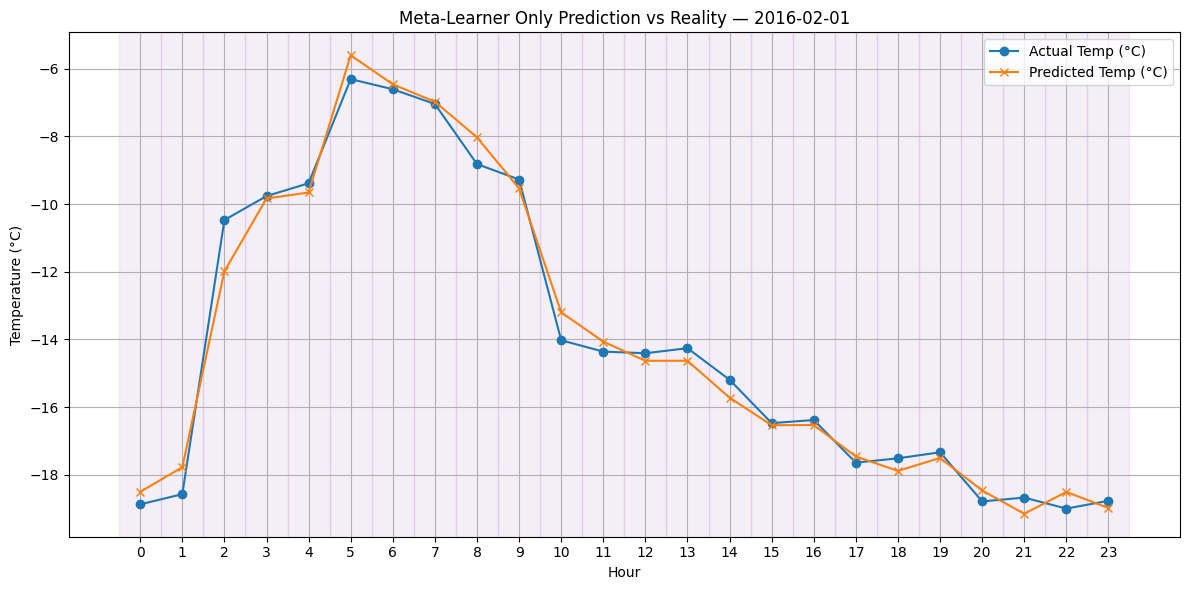

In [ ]:
df_result = predict_day_meta_only(
    date_str="2016-02-01",
    df_scaled=df,           # 经过 scaler.transform 后的 DataFrame
    df_raw=df.copy(),       # 原始未标准化数据
    scaler=scaler,
    all_cols=all_cols,
    models_dict=model_dicts,
    target_feature="t2m",
    seq_length=6
)
